No GPU available, using the CPU instead.


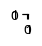

In [3]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import dataframe_image as dfi
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
f,a = plt.subplots(1,1,figsize=(1e-2, 1e-2))
mpl.rcParams['figure.dpi'] = 180
sns.set_style('darkgrid')
import os,sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import warnings
warnings.filterwarnings("ignore")

from tqdm.auto import tqdm
from datetime import datetime as dt
from src.utils import mkdirs, convert_path, pkl_dump, pkl_load, add_median_labels, get_palette
from src.data_processing import get_dataset, BL62_VALUES, BL62FREQ_VALUES, HLAS, AA_KEYS, get_aa_properties
from src.metrics import get_predictions, get_roc, get_metrics, plot_roc_auc_fold, get_mean_roc_curve
from src.metrics import get_nested_feature_importance, plot_feature_importance
from src.partition_tools import pipeline_stratified_kfold
from src.utils import pkl_load, pkl_dump
from src.baselines import plot_baseline_roc, plot_related_baseline_roc
from src.models import FFNetPipeline

PAL = sns.color_palette('hsv', n_colors=13)
HSV = [PAL[-4], PAL[-1], PAL[0], PAL [4]]
tmppal = sns.color_palette('hsv', n_colors=15)
NEWPAL = HSV + [tmppal[-3], tmppal[7]]
mpl.rcParams['figure.dpi'] = 180

import torch
from torch import optim, nn
import torch.functional as F
from torch.utils.data import DataLoader, TensorDataset

if torch.cuda.is_available():
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name())
    device="cuda:0"
else:
    print('No GPU available, using the CPU instead.')
    device='cpu'
    
sns.set_palette(get_palette('gnuplot2_r', 2))

In [ ]:
cedar_aligned = pd.read_csv('../data/aligned_icore/230418_cedar_aligned.csv')
prime_aligned = pd.read_csv('../data/aligned_icore/230418_prime_aligned.csv')
nepdb_aligned = pd.read_csv('../data/aligned_icore/230418_nepdb_aligned.csv')
cedar_expr = pd.read_csv('../data/pepx/230418_cedar_aligned_pepx.csv')
prime_expr = pd.read_csv('../data/pepx/230418_prime_aligned_pepx.csv')
nepdb_expr = pd.read_csv('../data/pepx/230418_nepdb_aligned_pepx.csv')
# ICS DICT
ics_kl = pkl_load('../data/ic_dicts/ics_kl_new.pkl')
ics_shannon = pkl_load('../data/ic_dicts/ics_shannon.pkl')

# (230721) Rank preds + pruning

## aucs

In [69]:
from src.utils import display_side_by_side
df = pd.read_csv('../output/230724_TrainDataPruning_CompareModels/total_df.csv')

for evalset in ['KCV', 'PRIME', 'NEPDB']:
    tmp = df.query('evalset==@evalset')
    cdt='not (pruned==False and condition!=1)'
    tmp = tmp.query(cdt)
    a = tmp.query('model_name=="consensus"').rename(columns = {'condition':'%Rank'}).groupby(['pruned','model_name','evalset','%Rank']).agg(mean_auc=('auc','mean')).sort_values('mean_auc',ascending=False)
    b = tmp.query('model_name=="base"').rename(columns = {'condition':'%Rank'}).groupby(['pruned','model_name','evalset','%Rank']).agg(mean_auc=('auc','mean')).sort_values('mean_auc',ascending=False)
    display_side_by_side(a,b)

mean_auc 
 
 
 pruned 
 model_name 
 evalset 
 %Rank 
 
 
 
 
 
 True 
 consensus 
 KCV 
 13 
 0.731816 
 
 
 11 
 0.731722 
 
 
 15 
 0.731674 
 
 
 9 
 0.731373 
 
 
 12 
 0.731219 
 
 
 14 
 0.731040 
 
 
 10 
 0.730974 
 
 
 8 
 0.730384 
 
 
 7 
 0.729181 
 
 
 4 
 0.728816 
 
 
 6 
 0.728388 
 
 
 3 
 0.727994 
 
 
 5 
 0.727935 
 
 
 2 
 0.727168 
 
 
 1 
 0.725480 
 
 
 False 
 consensus 
 KCV 
 1 
 0.718244 
 
 
 
 
 
 
 
 
 
 mean_auc 
 
 
 pruned 
 model_name 
 evalset 
 %Rank 
 
 
 
 
 
 True 
 base 
 KCV 
 13 
 0.730376 
 
 
 12 
 0.729777 
 
 
 9 
 0.729605 
 
 
 14 
 0.728899 
 
 
 11 
 0.728842 
 
 
 10 
 0.728549 
 
 
 8 
 0.728319 
 
 
 15 
 0.728153 
 
 
 7 
 0.728068 
 
 
 6 
 0.727247 
 
 
 5 
 0.726438 
 
 
 4 
 0.725795 
 
 
 2 
 0.725044 
 
 
 3 
 0.724569 
 
 
 1 
 0.723242 
 
 
 False 
 base 
 KCV 
 1 
 0.719495

mean_auc 
 
 
 pruned 
 model_name 
 evalset 
 %Rank 
 
 
 
 
 
 False 
 consensus 
 PRIME 
 1 
 0.720532 
 
 
 True 
 consensus 
 PRIME 
 1 
 0.719105 
 
 
 2 
 0.718385 
 
 
 3 
 0.716998 
 
 
 4 
 0.715391 
 
 
 5 
 0.711619 
 
 
 6 
 0.711025 
 
 
 7 
 0.710781 
 
 
 9 
 0.709100 
 
 
 8 
 0.708660 
 
 
 10 
 0.706624 
 
 
 11 
 0.706515 
 
 
 12 
 0.705802 
 
 
 13 
 0.705609 
 
 
 15 
 0.705412 
 
 
 14 
 0.705088 
 
 
 
 
 
 
 
 
 
 mean_auc 
 
 
 pruned 
 model_name 
 evalset 
 %Rank 
 
 
 
 
 
 False 
 base 
 PRIME 
 1 
 0.693586 
 
 
 True 
 base 
 PRIME 
 1 
 0.692512 
 
 
 10 
 0.689835 
 
 
 7 
 0.689638 
 
 
 8 
 0.689581 
 
 
 2 
 0.689508 
 
 
 6 
 0.689450 
 
 
 9 
 0.689368 
 
 
 5 
 0.689146 
 
 
 4 
 0.688667 
 
 
 11 
 0.688264 
 
 
 13 
 0.688052 
 
 
 3 
 0.687920 
 
 
 12 
 0.686896 
 
 
 14 
 0.685353 
 
 
 15 
 0.682858

mean_auc 
 
 
 pruned 
 model_name 
 evalset 
 %Rank 
 
 
 
 
 
 False 
 consensus 
 NEPDB 
 1 
 0.807481 
 
 
 True 
 consensus 
 NEPDB 
 4 
 0.794039 
 
 
 1 
 0.794025 
 
 
 2 
 0.791556 
 
 
 3 
 0.789349 
 
 
 5 
 0.787376 
 
 
 6 
 0.786638 
 
 
 8 
 0.785915 
 
 
 7 
 0.785426 
 
 
 9 
 0.784457 
 
 
 10 
 0.782909 
 
 
 11 
 0.781232 
 
 
 13 
 0.780582 
 
 
 12 
 0.778299 
 
 
 14 
 0.775403 
 
 
 15 
 0.768257 
 
 
 
 
 
 
 
 
 
 mean_auc 
 
 
 pruned 
 model_name 
 evalset 
 %Rank 
 
 
 
 
 
 False 
 base 
 NEPDB 
 1 
 0.728021 
 
 
 True 
 base 
 NEPDB 
 1 
 0.722324 
 
 
 2 
 0.720083 
 
 
 3 
 0.709922 
 
 
 4 
 0.698596 
 
 
 5 
 0.688044 
 
 
 6 
 0.683410 
 
 
 7 
 0.679315 
 
 
 8 
 0.673397 
 
 
 9 
 0.671004 
 
 
 10 
 0.669018 
 
 
 11 
 0.664364 
 
 
 12 
 0.660129 
 
 
 13 
 0.658401 
 
 
 14 
 0.657985 
 
 
 15 
 0.653789

In [4]:
%ls ../output/230721_TrainDataPruning/

bootstrapping/ raw/           total_df.csv


## stats

In [110]:
preds_100k = pd.read_csv('../data/human_proteome/preds_100k.txt', header=None)
pruned = pd.read_csv('../output/230721_TrainDataPruning/raw/KCV_preds_PruningTrue_Percentile_05.csv')
pruned.head()

,Peptide,HLA,EL_rank_mut,agg_label,fold,EL_rank_wt,EL_rank_wt_aligned,Total_Gene_TPM,Total_Peptide_TPM,Total_Scaled_Peptide_TPM,...,trueHLA_EL_rank,wild_type,foreignness_score,ratio_rank,impr_icore,impr_pep,ic_len,expanded_input,ratio_rank_squared,mean_pred
0,AAAAAAQQIQV,HLA-B0702,3.9712,0,5,1.0441,1.0441,4.41098,4.411,2.942,...,26.7692,AAAAAAQQLQV,0.0,11.133129,False,False,73978,AAAAAAQQI,15.104329,0.091868
1,AAAAQQIQV,HLA-A0201,1.9555,0,5,2.2847,2.2847,4.41098,4.411,2.942,...,1.9555,AAAAQQLQV,0.0,0.281766,False,False,83295,AAAAQQIQV,1.673734,0.126617
2,AAAAQQIQV,HLA-B0702,4.9092,0,5,4.7746,4.7746,4.41098,4.411,2.942,...,4.9092,AAAAQQLQV,0.0,0.138394,False,False,73978,AAAAQQIQV,5.047594,0.128013
3,AAHFTVLLY,HLA-A1101,0.4196,0,6,0.5881,0.5881,8.35072,8.351,1.194,...,0.4196,AAHFTALLY,0.0,0.120222,False,False,74135,AAHFTVLLY,0.299378,0.341299
4,AAIAASRSV,HLA-C1203,0.0591,0,6,1.1729,1.1729,20.89090,20.891,4.178,...,0.0591,AAIAASRSA,0.0,0.056122,True,True,94776,AAIAASRSV,0.002978,0.240065


In [71]:
%ls ../output/230724_TrainDataPruning_CompareModels/raw | grep KCV | tail

KCV_preds_consensus_PruningTrue_Percentile_06.csv
KCV_preds_consensus_PruningTrue_Percentile_07.csv
KCV_preds_consensus_PruningTrue_Percentile_08.csv
KCV_preds_consensus_PruningTrue_Percentile_09.csv
KCV_preds_consensus_PruningTrue_Percentile_10.csv
KCV_preds_consensus_PruningTrue_Percentile_11.csv
KCV_preds_consensus_PruningTrue_Percentile_12.csv
KCV_preds_consensus_PruningTrue_Percentile_13.csv
KCV_preds_consensus_PruningTrue_Percentile_14.csv
KCV_preds_consensus_PruningTrue_Percentile_15.csv


In [107]:
def get_misclassified(pred, label, bot, top):
    if pred<bot and label == 1:
        return 'FN'
    if pred>top and label == 0:
        return 'FP'
    else:
        return 'Normal'

df_cons = []
df_base = []
# For each percentile and model, check the number of datapoints removed
for p in range(1,16):
    base = pd.read_csv(f'../output/230724_TrainDataPruning_CompareModels/raw/KCV_preds_base_PruningTrue_Percentile_{p:02}.csv')
    cons = pd.read_csv(f'../output/230724_TrainDataPruning_CompareModels/raw/KCV_preds_consensus_PruningTrue_Percentile_{p:02}.csv')
    
    base['class'] = base.apply(lambda x: get_misclassified(x['mean_pred'], x['agg_label'], bot, top), axis=1)
    base['misclassified'] = base['class'] != 'Normal'
    cons['class'] = cons.apply(lambda x: get_misclassified(x['mean_pred'], x['agg_label'], bot, top), axis=1)
    cons['misclassified'] = cons['class'] != 'Normal'
    
    x = pd.DataFrame(cons.groupby(['class']).agg(count=('Peptide','count')).to_dict()['count'], index=[0]).rename(columns = {'Normal':'Correct (FinalPrunedTrainSize)'})
    x['Misclassified']=x['FN']+x['FP']
    x['Percentile'] = p
    df_cons.append(x[['Percentile','Correct (FinalPrunedTrainSize)', 'Misclassified', 'FN', 'FP']])
    
    x = pd.DataFrame(base.groupby(['class']).agg(count=('Peptide','count')).to_dict()['count'], index=[0]).rename(columns = {'Normal':'Correct (FinalPrunedTrainSize)'})
    x['Misclassified']=x['FN']+x['FP']
    x['Percentile'] = p
    df_base.append(x[['Percentile','Correct (FinalPrunedTrainSize)', 'Misclassified', 'FN', 'FP']])

In [108]:
pd.concat(df_cons).set_index('Percentile')

,Correct (FinalPrunedTrainSize),Misclassified,FN,FP
Percentile,,,,
1,2508,480,8,472
2,2430,558,8,550
3,2363,625,9,616
4,2329,659,8,651
5,2269,719,8,711
6,2212,776,9,767
7,2188,800,10,790
8,2163,825,12,813
9,2135,853,10,843


In [109]:
pd.concat(df_base).set_index('Percentile')

,Correct (FinalPrunedTrainSize),Misclassified,FN,FP
Percentile,,,,
1,2479,509,14,495
2,2387,601,16,585
3,2326,662,16,646
4,2267,721,16,705
5,2208,780,16,764
6,2177,811,17,794
7,2144,844,16,828
8,2115,873,16,857
9,2084,904,16,888


In [114]:
# Select (randomly 5% Rank and check the misclassified counts per fold)
percentile_thr = 5
bot, top = [percentile_thr/100, (100-percentile_thr)/100]
bot, top = preds_100k.describe(percentiles=[bot, top]).loc[[f'{bot:.0%}', f'{top:.0%}']].values

pruned = pd.read_csv('../output/230724_TrainDataPruning_CompareModels/raw/KCV_preds_consensus_PruningTrue_Percentile_05.csv')
pruned['class'] = pruned.apply(lambda x: get_misclassified(x['mean_pred'], x['agg_label'], bot, top), axis=1)
pruned['misclassified'] = pruned['class'] != 'Normal'

(pruned.query('misclassified').groupby(['fold','misclassified']).agg(count=('Peptide','count')) / pruned.groupby(['fold']).agg(count=('Peptide','count'))).sort_values('count', ascending=False).rename(columns={'count':'% Misclassified in fold'})

,,% Misclassified in fold
fold,misclassified,
7,True,0.294521
3,True,0.282051
4,True,0.251656
2,True,0.242525
9,True,0.235294
1,True,0.234694
6,True,0.225705
8,True,0.221843
0,True,0.209220


## Feat Dist

In [120]:
# Select (randomly 5% Rank and check the misclassified counts per fold)
percentile_thr = 5
bot, top = [percentile_thr/100, (100-percentile_thr)/100]
bot, top = preds_100k.describe(percentiles=[bot, top]).loc[[f'{bot:.0%}', f'{top:.0%}']].values

pruned = pd.read_csv('../output/230724_TrainDataPruning_CompareModels/raw/KCV_preds_base_PruningTrue_Percentile_05.csv')
pruned['class'] = pruned.apply(lambda x: get_misclassified(x['mean_pred'], x['agg_label'], bot, top), axis=1)
pruned['misclassified'] = pruned['class'] != 'Normal'

(pruned.query('misclassified').groupby(['fold','misclassified']).agg(count=('Peptide','count')) / pruned.groupby(['fold']).agg(count=('Peptide','count'))).sort_values('count', ascending=False).rename(columns={'count':'% Misclassified in fold'})

,,% Misclassified in fold
fold,misclassified,
0,True,0.283688
1,True,0.282313
7,True,0.280822
6,True,0.269592
8,True,0.262799
4,True,0.258278
5,True,0.254355
3,True,0.250000
9,True,0.248366


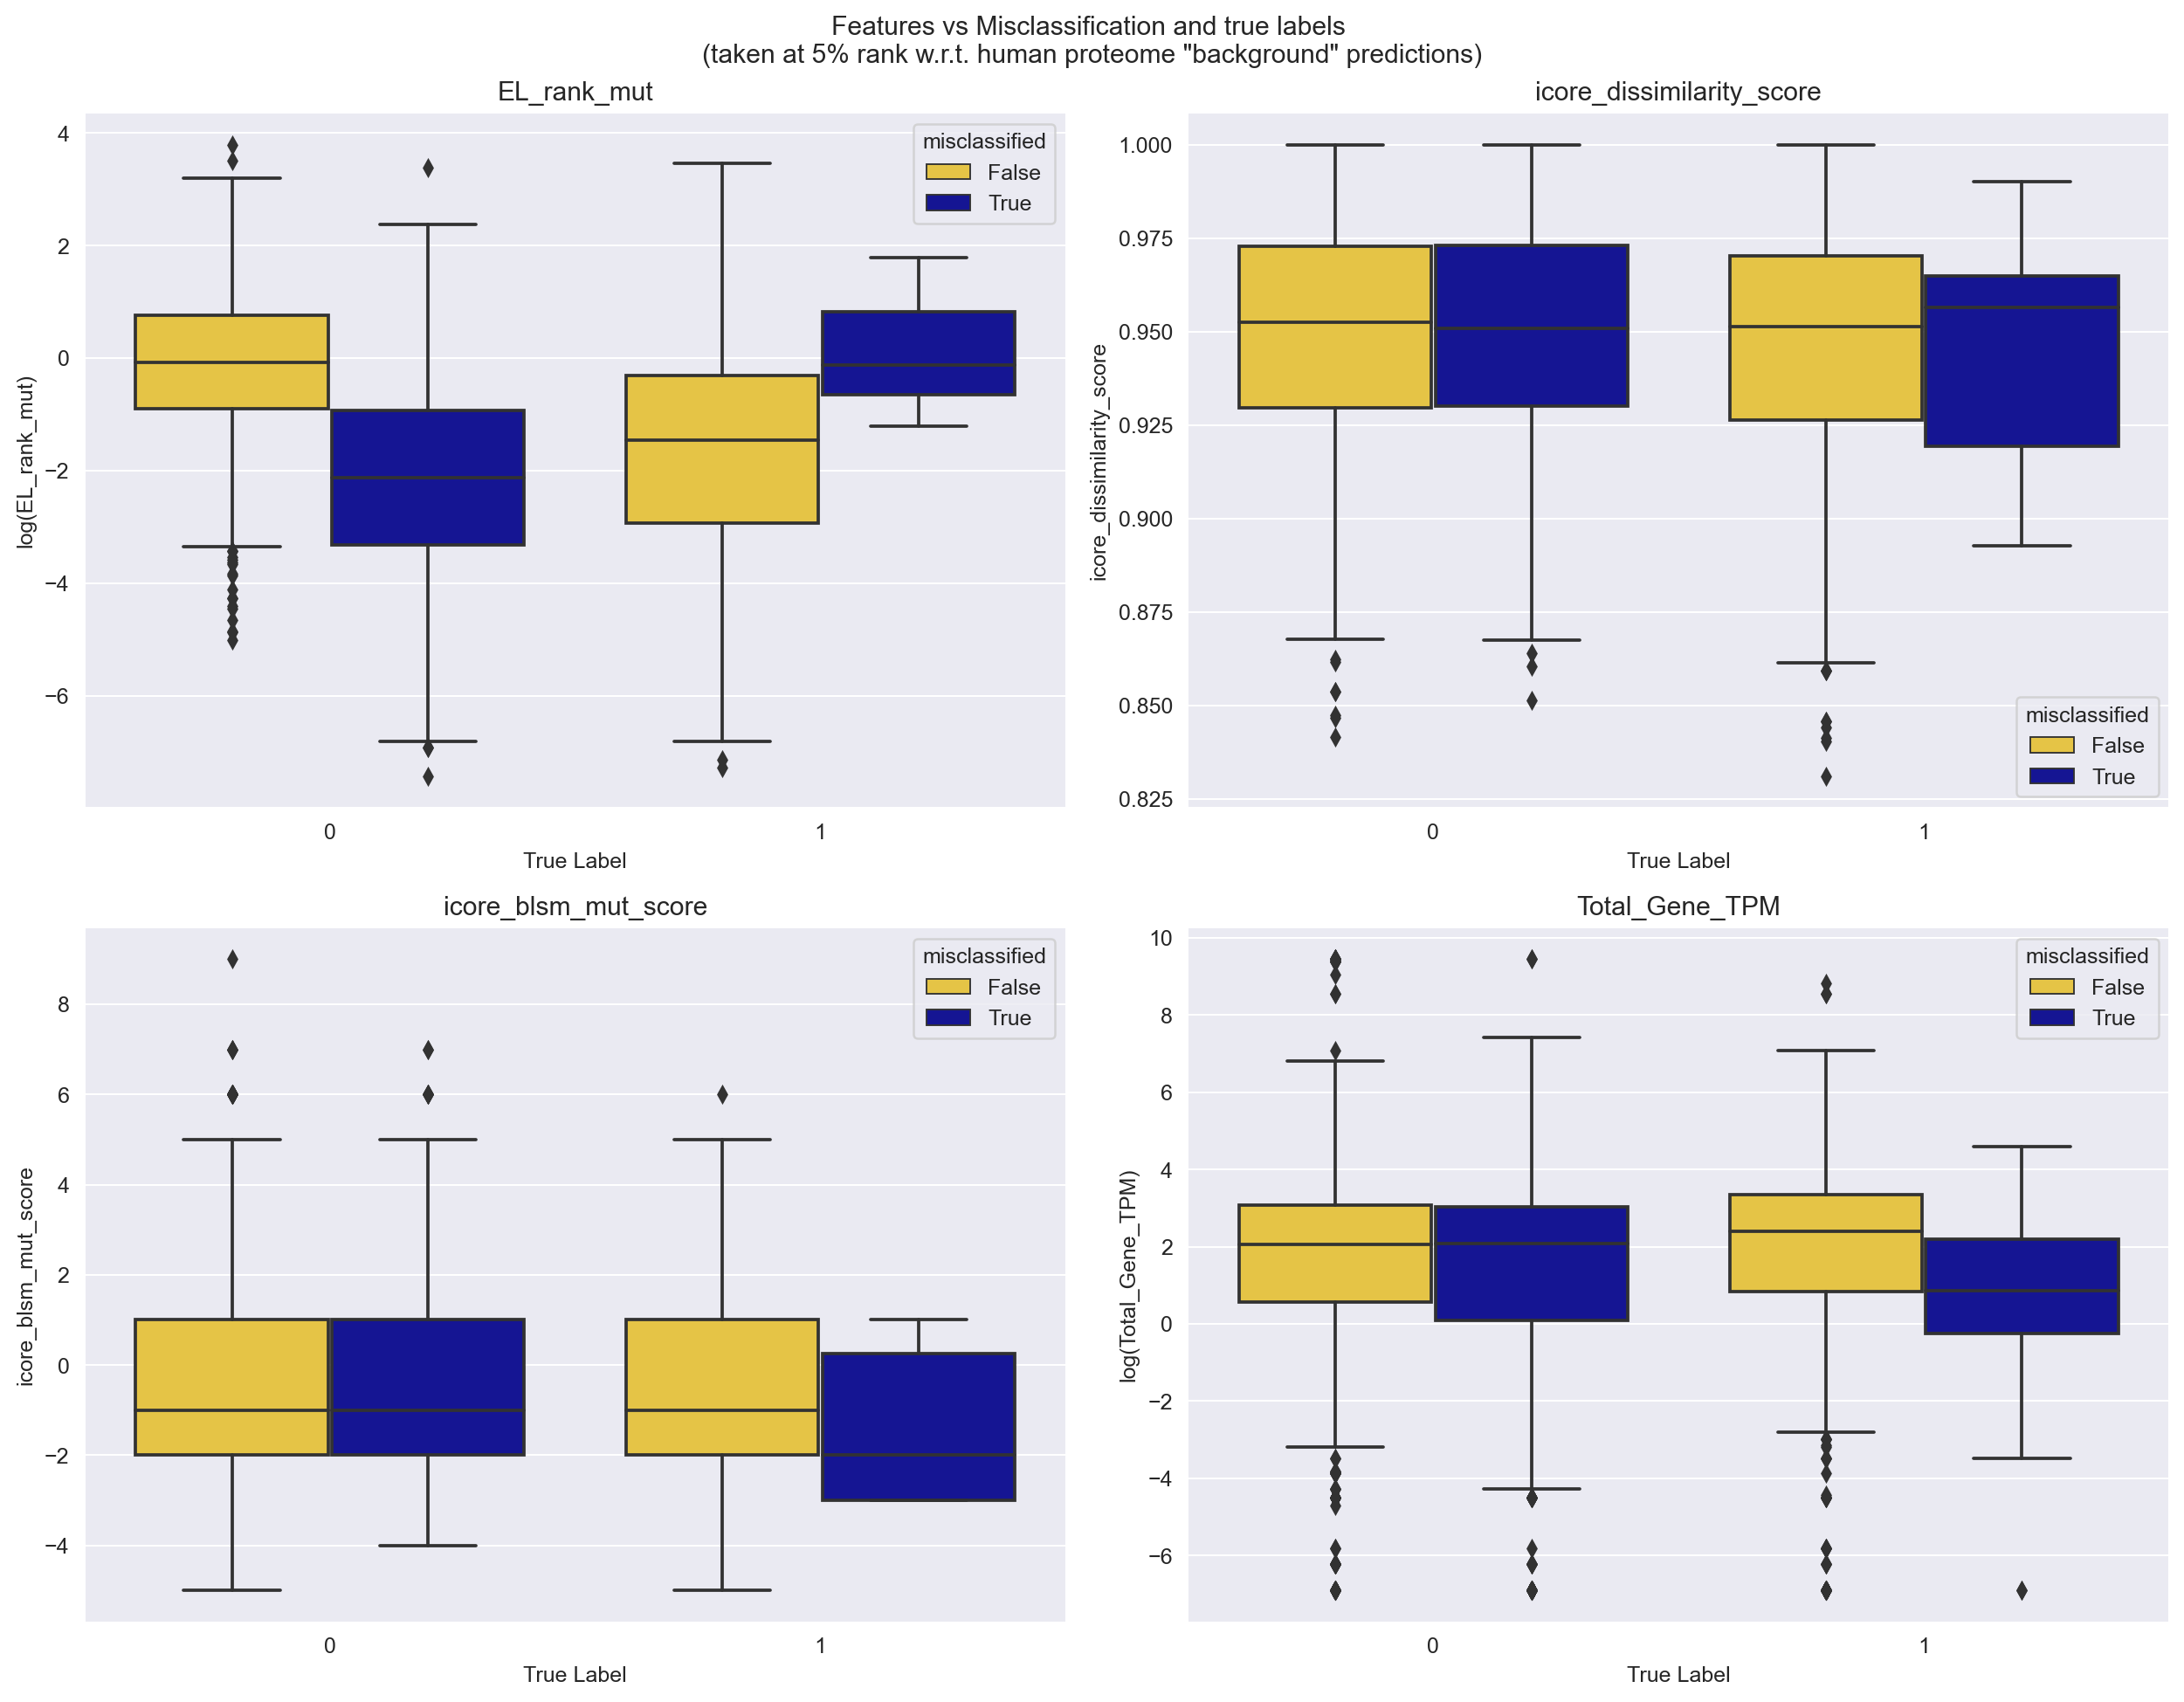

In [121]:
# folds 3,4,7 most misclassified at 28.2, 29.4, 25.1%
pruned['selected'] = pruned.apply(lambda x: x['fold'] in [3,4,7] and x['misclassified'], axis=1)#.query('fold in [3,4,7] and misclassified')
fig,a = plt.subplots(2,2, figsize=(14,11))
a = a.ravel()
for i,f in enumerate(['EL_rank_mut', 'icore_dissimilarity_score', 'icore_blsm_mut_score', 'Total_Gene_TPM']):
    if 'score' not in f:
        pruned['tmp'] = pruned[f].apply(np.log)
        lab = f'log({f})'
    else:
        pruned['tmp'] = pruned[f]
        lab=f
    sns.boxplot(data = pruned, hue='misclassified', x='agg_label', y='tmp', ax=a[i])
    a[i].set_title(f)#.groupby(['label']).plot(kind='hist', density=True)
    a[i].set_xlabel('True Label')
    a[i].set_ylabel(lab)
fig.suptitle('Features vs Misclassification and true labels \n(taken at 5% rank w.r.t. human proteome "background" predictions)')
fig.tight_layout()
# Seems like the misclassified points have lower rank, lower ratio rank, and higher TPM than the properly classified (for false positives)
# And the opposite for the false negatives
# So maybe check the feature importances ; But seems like the problem here comes from the extra features ? 
# Should check whether the same datapoints are misclassified for the base model -> change script

In [118]:
# Select (randomly 5% Rank and check the misclassified counts per fold)
percentile_thr = 5
bot, top = [percentile_thr/100, (100-percentile_thr)/100]
bot, top = preds_100k.describe(percentiles=[bot, top]).loc[[f'{bot:.0%}', f'{top:.0%}']].values

pruned = pd.read_csv('../output/230724_TrainDataPruning_CompareModels/raw/KCV_preds_consensus_PruningTrue_Percentile_05.csv')
pruned['class'] = pruned.apply(lambda x: get_misclassified(x['mean_pred'], x['agg_label'], bot, top), axis=1)
pruned['misclassified'] = pruned['class'] != 'Normal'

(pruned.groupby(['fold','misclassified']).agg(count=('Peptide','count')) / pruned.groupby(['fold']).agg(count=('Peptide','count'))).sort_values('count', ascending=False)

,,count
fold,misclassified,
5,False,0.794425
0,False,0.790780
8,False,0.778157
6,False,0.774295
1,False,0.765306
9,False,0.764706
2,False,0.757475
4,False,0.748344
3,False,0.717949


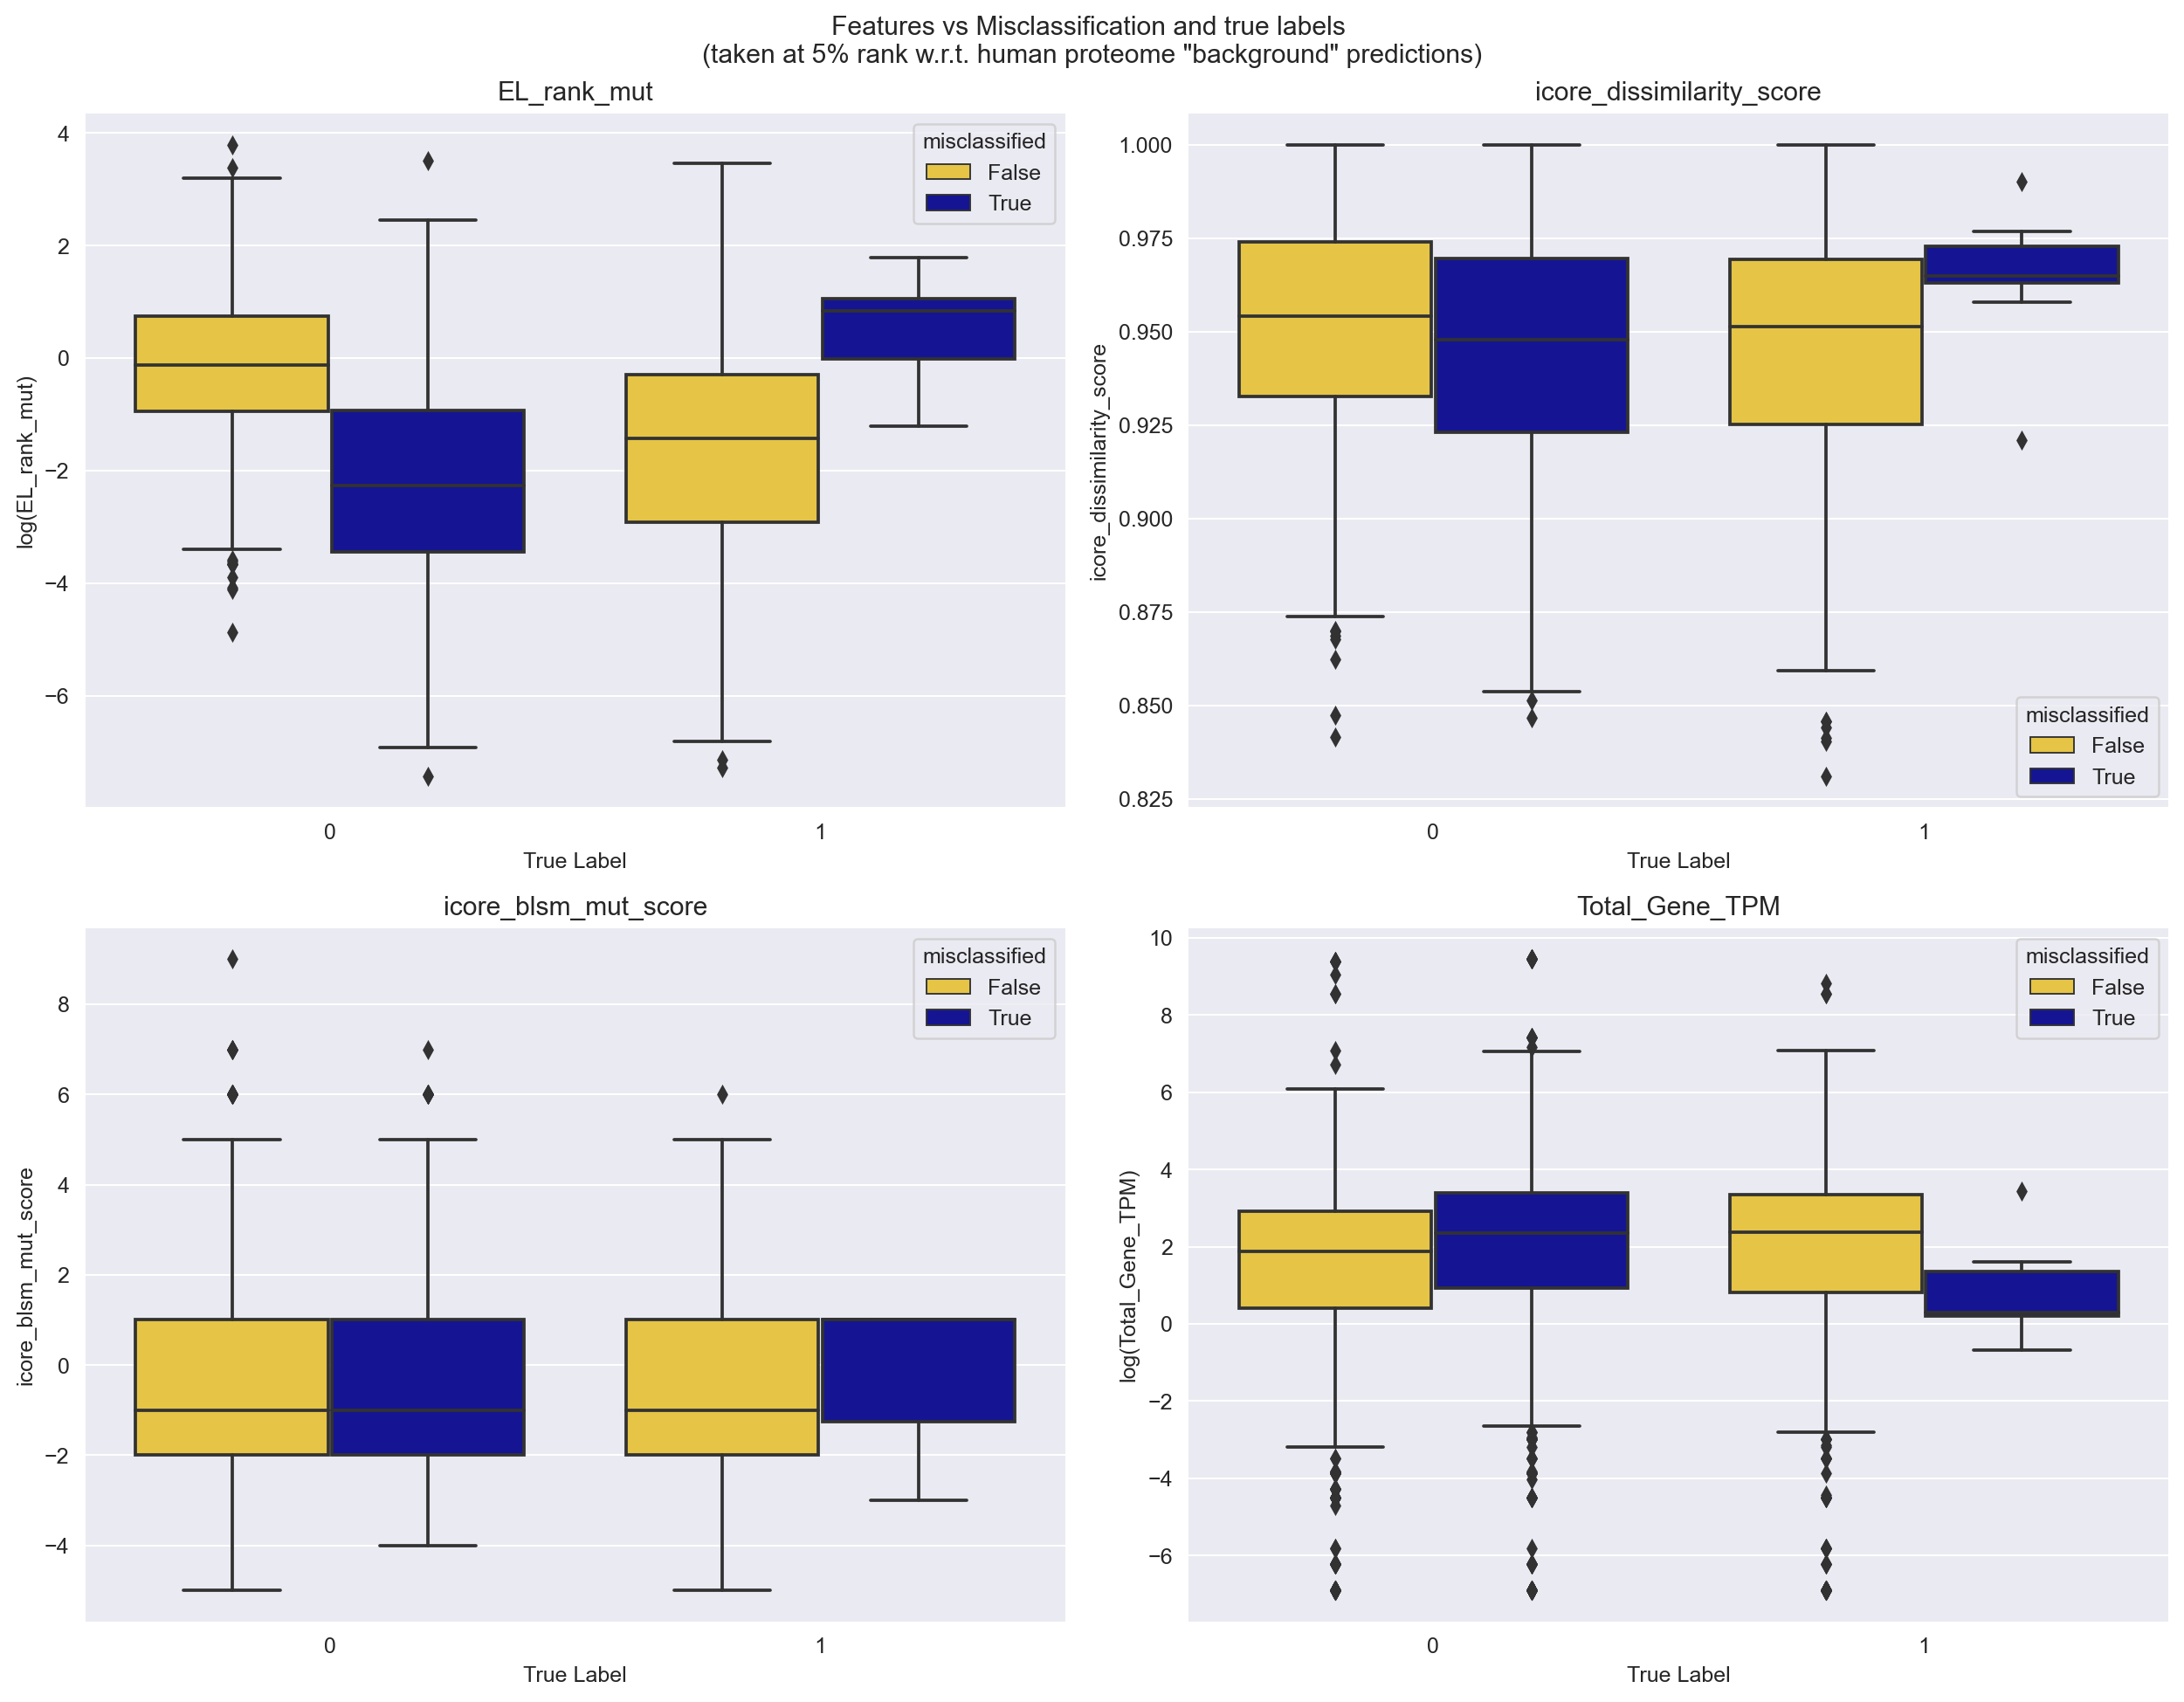

In [119]:
# folds 3,4,7 most misclassified at 28.2, 29.4, 25.1%
pruned['selected'] = pruned.apply(lambda x: x['fold'] in [3,4,7] and x['misclassified'], axis=1)#.query('fold in [3,4,7] and misclassified')
fig,a = plt.subplots(2,2, figsize=(14,11))
a = a.ravel()
for i,f in enumerate(['EL_rank_mut', 'icore_dissimilarity_score', 'icore_blsm_mut_score', 'Total_Gene_TPM']):
    if 'score' not in f:
        pruned['tmp'] = pruned[f].apply(np.log)
        lab = f'log({f})'
    else:
        pruned['tmp'] = pruned[f]
        lab=f
    sns.boxplot(data = pruned, hue='misclassified', x='agg_label', y='tmp', ax=a[i])
    a[i].set_title(f)#.groupby(['label']).plot(kind='hist', density=True)
    a[i].set_xlabel('True Label')
    a[i].set_ylabel(lab)
fig.suptitle('Features vs Misclassification and true labels \n(taken at 5% rank w.r.t. human proteome "background" predictions)')
fig.tight_layout()
# Seems like the misclassified points have lower rank, lower ratio rank, and higher TPM than the properly classified (for false positives)
# And the opposite for the false negatives
# So maybe check the feature importances ; But seems like the problem here comes from the extra features ? 
# Should check whether the same datapoints are misclassified for the base model -> change script

## Feat Imps

In [124]:
from src.metrics import plot_feature_importance

In [125]:
fi_cons_noprune = pd.read_csv('../output/230724_TrainDataPruning_CompareModels/raw/featimps_consensus_PrunedFalse_Percentile_01.csv')
fi_base_noprune  = pd.read_csv('../output/230724_TrainDataPruning_CompareModels/raw/featimps_base_PrunedFalse_Percentile_01.csv')
fi_cons_5 = pd.read_csv('../output/230724_TrainDataPruning_CompareModels/raw/featimps_consensus_PrunedTrue_Percentile_05.csv')
fi_base_5 = pd.read_csv('../output/230724_TrainDataPruning_CompareModels/raw/featimps_base_PrunedTrue_Percentile_05.csv')

In [131]:
fi_cons_noprune.values

array([[0.02156254, 0.01738449, 0.0125827 , 0.02176686, 0.00667396,
        0.01571466, 0.01851036, 0.01558815, 0.01552772, 0.04969836,
        0.03851709, 0.01452677, 0.02732722, 0.05292573, 0.02086485,
        0.04209528, 0.02144894, 0.01244942, 0.05610054, 0.03668018,
        0.20979602, 0.10201248, 0.04688901, 0.12335668]])

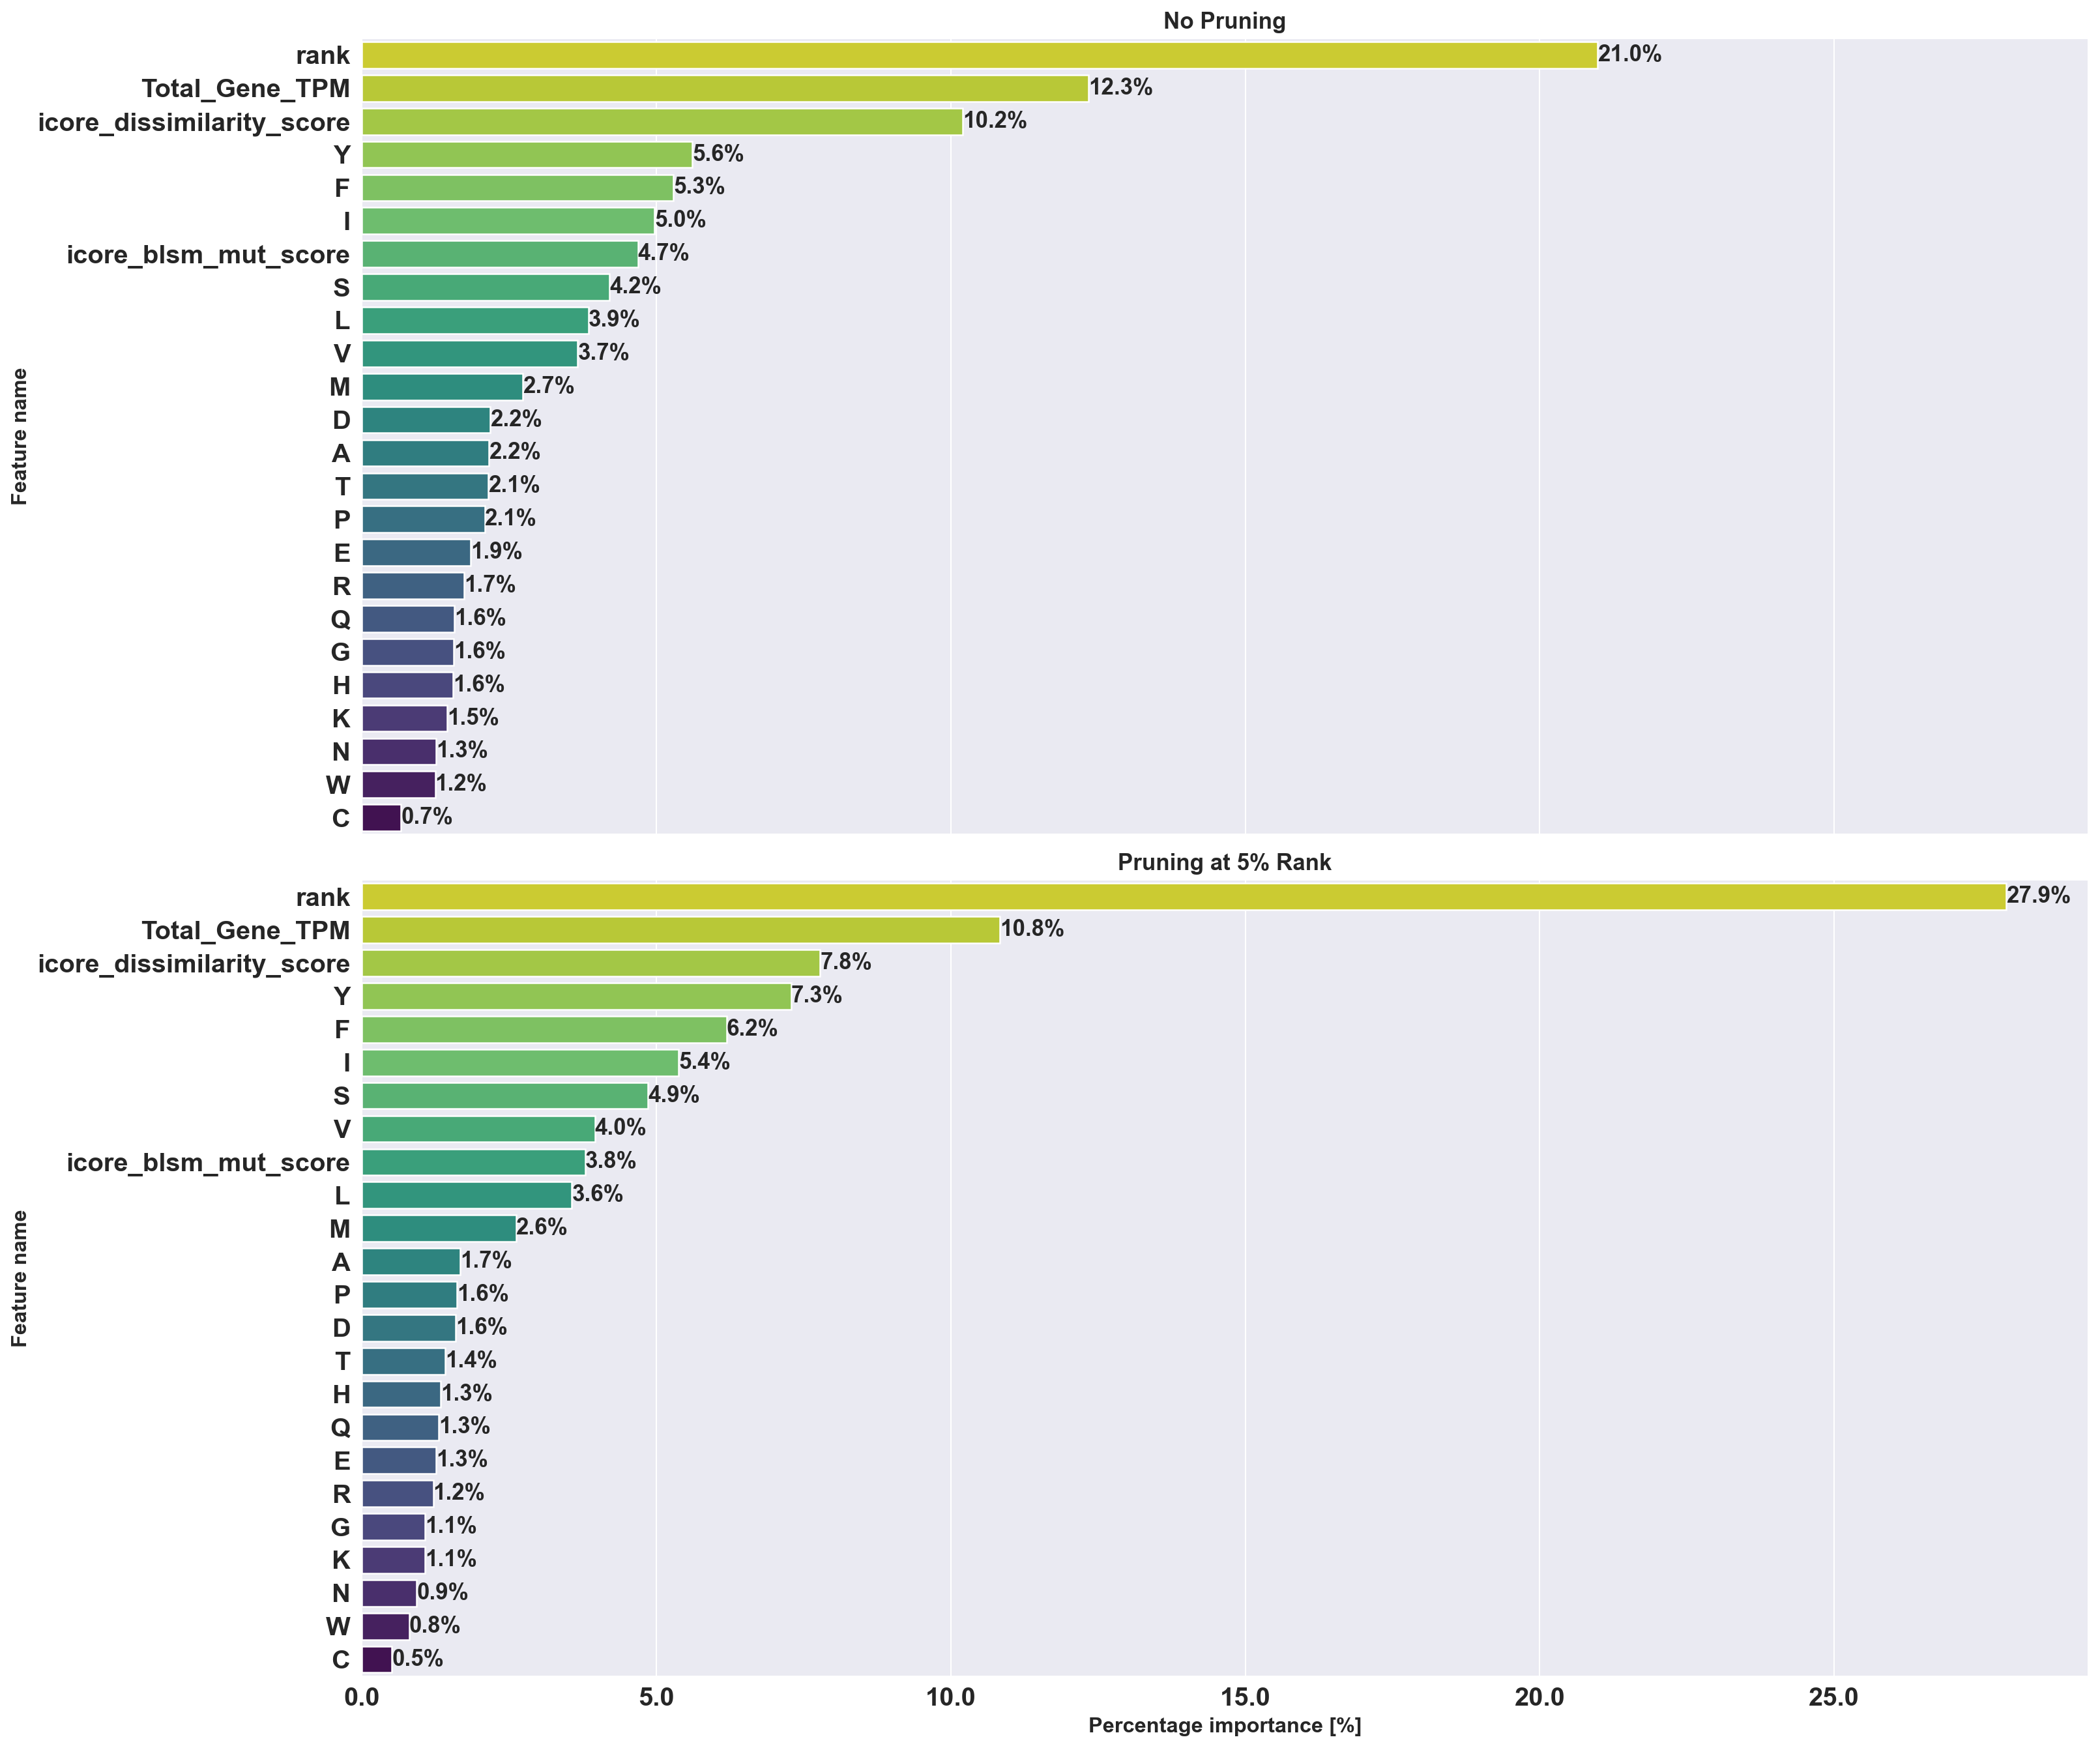

In [142]:
f,a = plt.subplots(2,1,figsize=(18,15), sharex=True)
a=a.ravel()
plot_feature_importance(fi_cons_noprune.values.flatten(), names = fi_cons_noprune.columns.values, title = 'No Pruning', ax=a[0], label_number=True)

plot_feature_importance(fi_cons_5.values.flatten(), names = fi_cons_5.columns.values, title = 'Pruning at 5% Rank', ax=a[1], label_number=True)
a[1].set_yticklabels(a[1].get_yticklabels(), fontsize=16, fontweight='semibold')
a[0].set_yticklabels(a[0].get_yticklabels(), fontsize=16, fontweight='semibold')
a[0].set_xlabel('')
a[1].set_xticklabels(a[1].get_xticklabels(), fontsize=16., fontweight='semibold')
f.tight_layout()

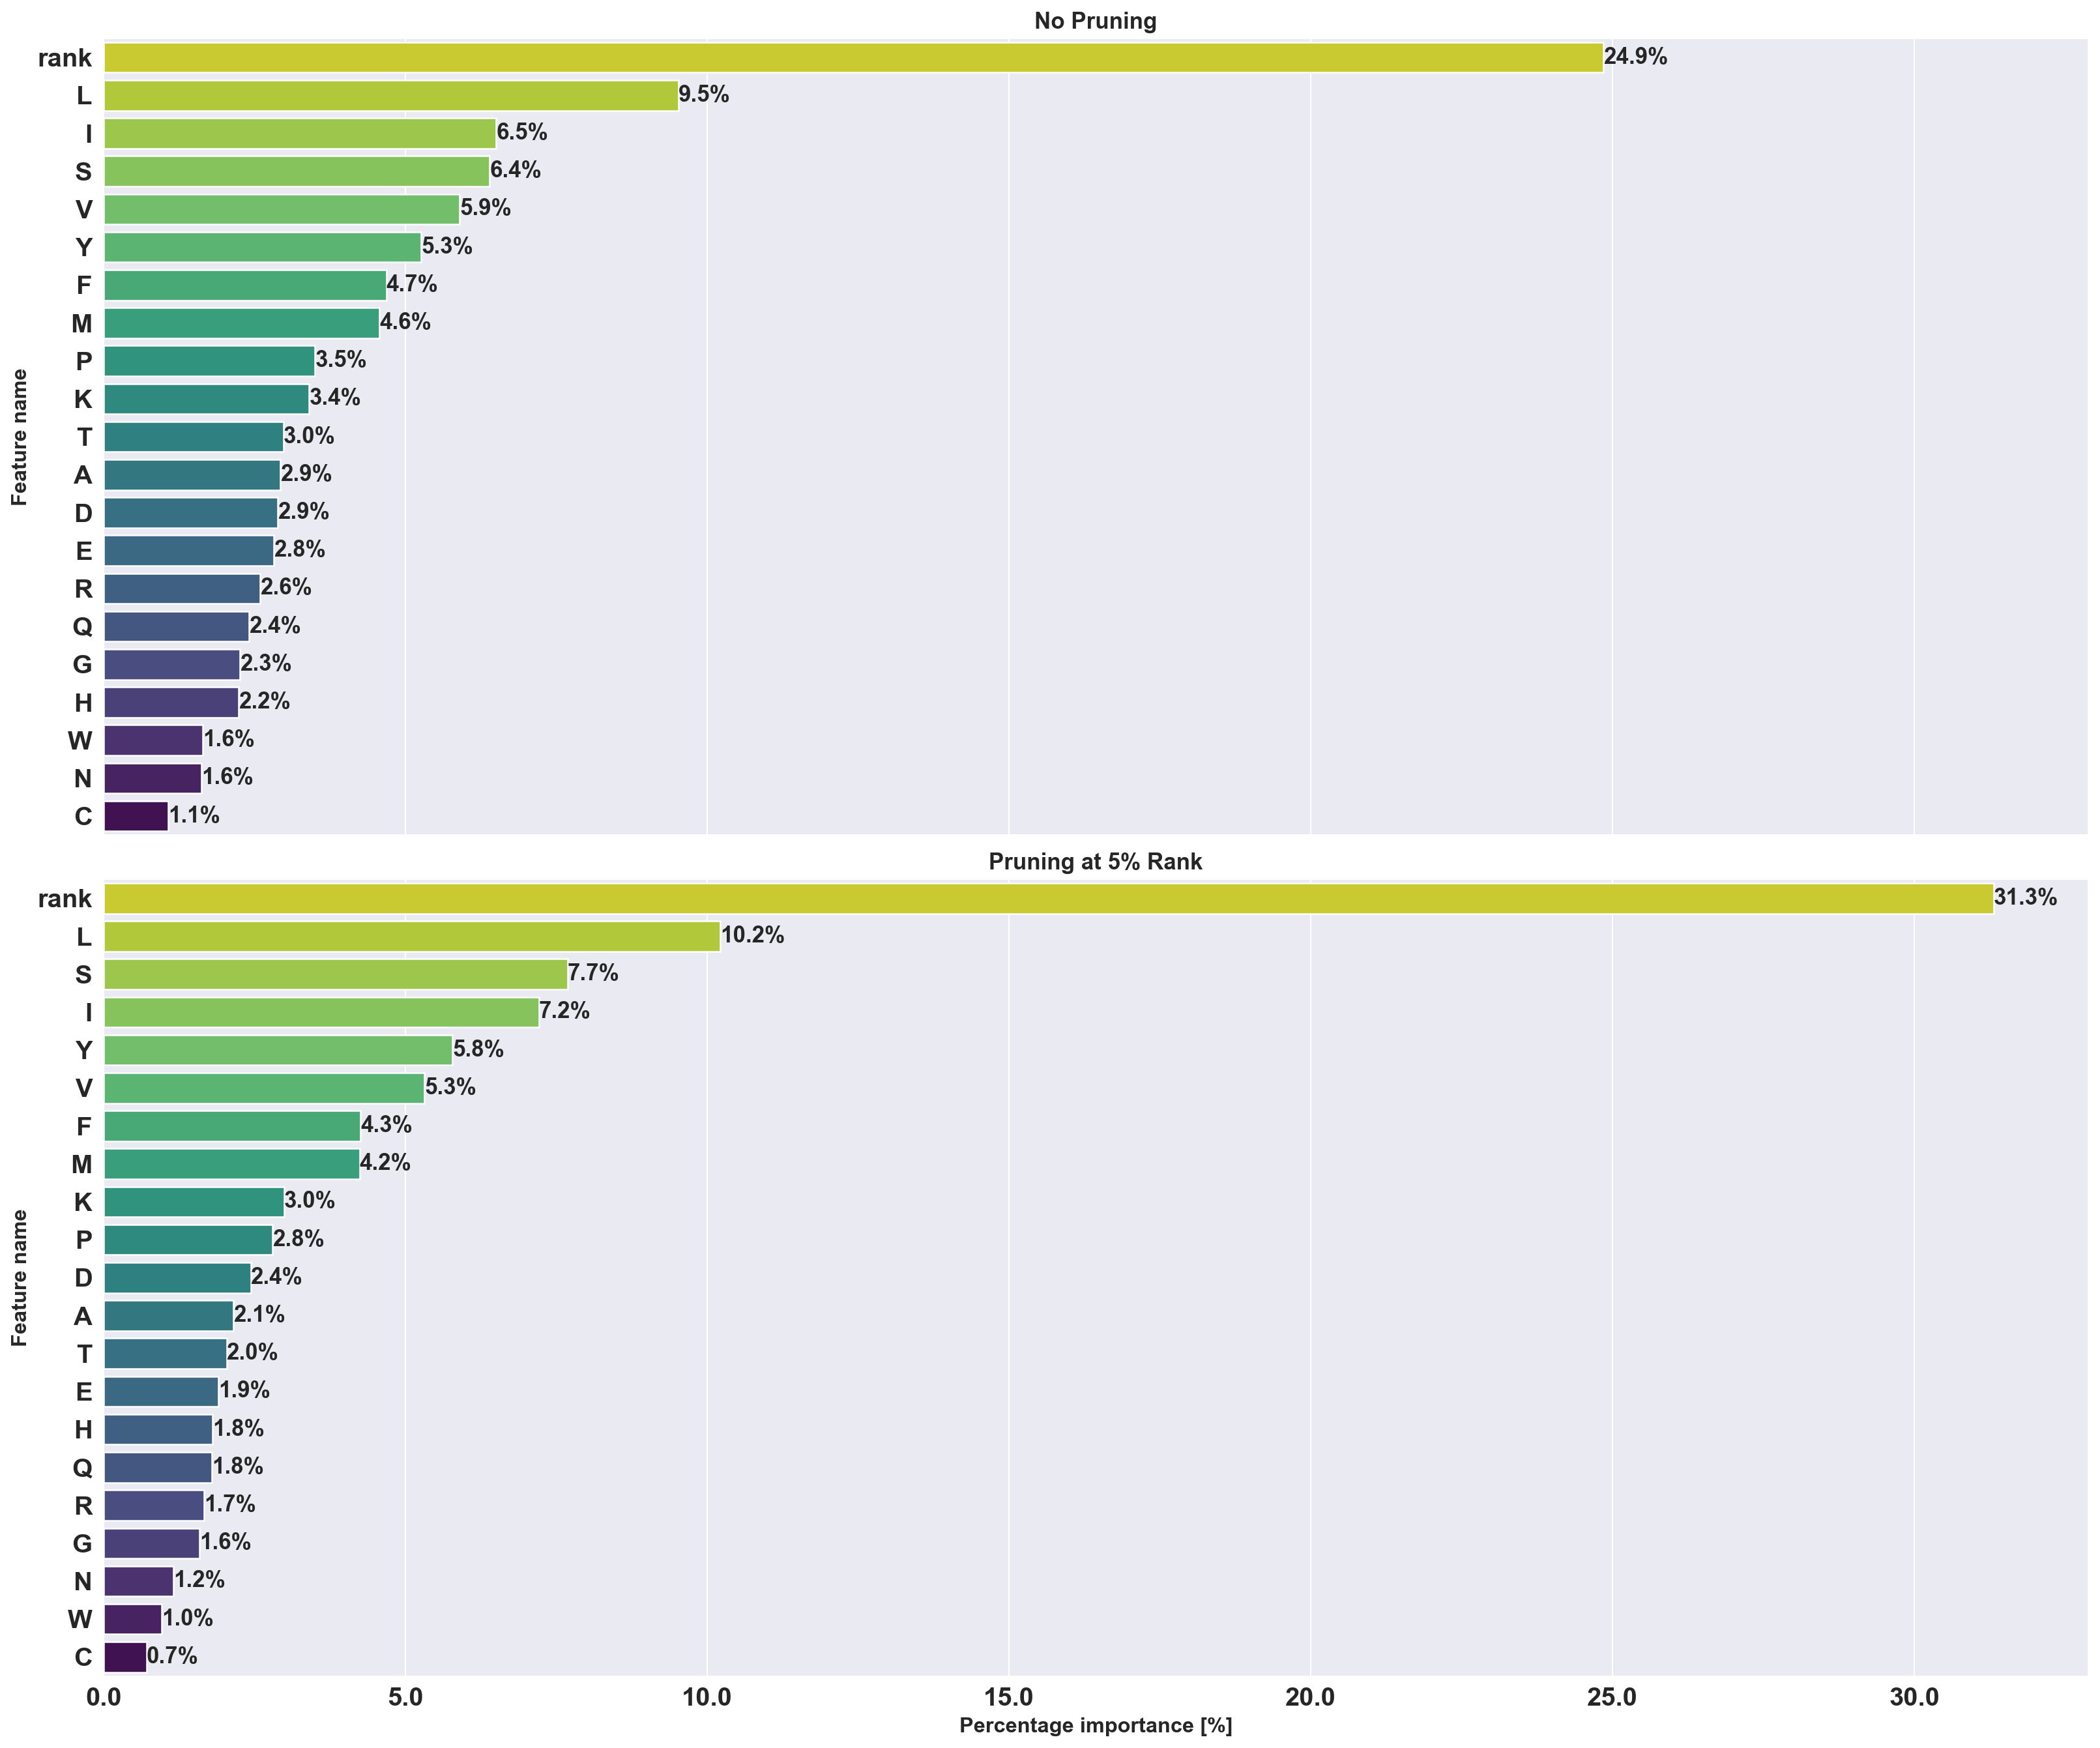

In [143]:
f,a = plt.subplots(2,1,figsize=(18,15), sharex=True)
a=a.ravel()
plot_feature_importance(fi_base_noprune.values.flatten(), names = fi_base_noprune.columns.values, title = 'No Pruning', ax=a[0], label_number=True)

plot_feature_importance(fi_base_5.values.flatten(), names = fi_base_5.columns.values, title = 'Pruning at 5% Rank', ax=a[1], label_number=True)
a[1].set_yticklabels(a[1].get_yticklabels(), fontsize=16, fontweight='semibold')
a[0].set_yticklabels(a[0].get_yticklabels(), fontsize=16, fontweight='semibold')
a[0].set_xlabel('')
a[1].set_xticklabels(a[1].get_xticklabels(), fontsize=16., fontweight='semibold')
f.tight_layout()

In [150]:
cedar_aligned.query('icore_mut==icore_wt_aligned').query('agg_label==1')[['agg_label','HLA','len','len_icore_mut', 'Peptide','wild_type','icore_mut','icore_wt_aligned','EL_rank_mut','EL_rank_wt_aligned','trueHLA_EL_rank']]

,agg_label,HLA,len,len_icore_mut,Peptide,wild_type,icore_mut,icore_wt_aligned,EL_rank_mut,EL_rank_wt_aligned,trueHLA_EL_rank
872,1,HLA-B3801,10,9,HQNPVTGLLL,HQNPVTGLLP,HQNPVTGLL,HQNPVTGLL,0.1582,0.1582,0.4505
1280,1,HLA-C1203,10,9,KTGEQRVVTL,ETGEQRVVTL,TGEQRVVTL,TGEQRVVTL,3.2579,3.2579,9.5707
1659,1,HLA-A0201,11,8,MLEYQKILWKV,MLKYQKILWKV,YQKILWKV,YQKILWKV,2.1404,2.1404,2.9861
1696,1,HLA-B3501,10,9,MPIEPGDIGC,MPIEPGDIGY,MPIEPGDIG,MPIEPGDIG,1.2170,1.2170,1.7386
1703,1,HLA-A0201,10,9,MQLMPFGCLL,TQLMPFGCLL,QLMPFGCLL,QLMPFGCLL,0.5522,0.5522,2.9729
1971,1,HLA-B3801,11,9,RHDLPPYRVYL,RHDLPPYRVHL,RHDLPPYRV,RHDLPPYRV,0.0253,0.0253,0.1253
2031,1,HLA-A0201,11,9,RLSCMLARLEV,RLSCMLARLEI,RLSCMLARL,RLSCMLARL,1.3674,1.3674,3.9007
2107,1,HLA-B5701,10,8,RTAVYHEIHI,RTAVYHEILI,RTAVYHEI,RTAVYHEI,3.6890,3.6890,3.8225
2515,1,HLA-A0201,11,9,TLIAIFPYARL,TLIAIFPYAGL,TLIAIFPYA,TLIAIFPYA,0.2600,0.2600,2.7494
2848,1,HLA-C0401,10,9,YFATLITELF,YFATLITELV,YFATLITEL,YFATLITEL,0.0760,0.0760,2.7089


# get stats for random datapruning

In [153]:
%ls ../output/230724_TrainDataPruning_CompareModels/raw | grep KCV | grep consensus | head

KCV_preds_consensus_PruningFalse_Percentile_01.csv
KCV_preds_consensus_PruningTrue_Percentile_01.csv
KCV_preds_consensus_PruningTrue_Percentile_02.csv
KCV_preds_consensus_PruningTrue_Percentile_03.csv
KCV_preds_consensus_PruningTrue_Percentile_04.csv
KCV_preds_consensus_PruningTrue_Percentile_05.csv
KCV_preds_consensus_PruningTrue_Percentile_06.csv
KCV_preds_consensus_PruningTrue_Percentile_07.csv
KCV_preds_consensus_PruningTrue_Percentile_08.csv
KCV_preds_consensus_PruningTrue_Percentile_09.csv


In [159]:

def get_misclassified(pred, label, bot, top):
    if pred < bot and label == 1:
        return 'FN'
    if pred > top and label == 0:
        return 'FP'
    else:
        return 'Normal'


In [191]:
df.groupby(['class']).count()

,index,Peptide,HLA,EL_rank_mut,agg_label,fold,EL_rank_wt,EL_rank_wt_aligned,Total_Gene_TPM,Total_Peptide_TPM,...,wild_type,foreignness_score,ratio_rank,impr_icore,impr_pep,ic_len,expanded_input,ratio_rank_squared,mean_pred,misclassified
class,,,,,,,,,,,,,,,,,,,,,
FN,8,8,8,8,8,8,8,8,8,8,...,8,8,8,8,8,8,8,8,8,8
FP,382,382,382,382,382,382,382,382,382,382,...,382,382,382,382,382,382,382,382,382,382
Normal,1991,1991,1991,1991,1991,1991,1991,1991,1991,1991,...,1991,1991,1991,1991,1991,1991,1991,1991,1991,1991


In [189]:
# For each percentile ; For each fold ; get number of + and - removed
fold_in=9
fold_out=2
perc=1

df = pd.read_csv(f'../output/230724_TrainDataPruning_CompareModels/raw/KCV_preds_consensus_PruningTrue_Percentile_{perc:02}.csv').query('fold!=@fold_in and fold !=@fold_out').reset_index()

df['class'] = df.apply(lambda x: get_misclassified(x['mean_pred'], x['agg_label'], bot, top),axis=1)
df['misclassified'] = df['class'] != 'Normal'
n_pos, n_neg = [x.item() for x in df.query('misclassified').groupby(['class']).agg(count=('Peptide','count')).rename(index={'FN':'pos', 'FP':'neg'}).values]
pos_index = df.query('agg_label==1').sample(n_pos).index
neg_index = df.query('agg_label==0').sample(n_neg).index

In [213]:
df = pd.read_csv(f'../output/230724_TrainDataPruning_CompareModels/raw/KCV_preds_consensus_PruningTrue_Percentile_{1:02}.csv').query('fold!=0 and fold !=1').reset_index()
df['class'] = df.apply(lambda x: get_misclassified(x['mean_pred'], x['agg_label'], bot, top),axis=1)
df['misclassified'] = df['class'] != 'Normal'
df = df.query('misclassified').groupby(['class']).agg(count=('Peptide', 'count')).rename(
                                index={'FN': 'pos', 'FP': 'neg'})
df

,count
class,
neg,261


In [216]:
'neg' in df.index

True

In [217]:
df.loc['neg'].item()

261

In [181]:
len(df), len(df.drop(pos_index.join(neg_index, how='outer')))

(2374, 2000)

In [177]:
df.drop(pos_index.join(neg_index))

,Peptide,HLA,EL_rank_mut,agg_label,fold,EL_rank_wt,EL_rank_wt_aligned,Total_Gene_TPM,Total_Peptide_TPM,Total_Scaled_Peptide_TPM,...,foreignness_score,ratio_rank,impr_icore,impr_pep,ic_len,expanded_input,ratio_rank_squared,mean_pred,class,misclassified
0,AAAAAAQQIQV,HLA-B0702,3.9712,0,5,1.0441,1.0441,4.41098,4.411,2.942,...,0.0,11.133129,False,False,73978,AAAAAAQQI,15.104329,0.095547,Normal,False
1,AAAAQQIQV,HLA-A0201,1.9555,0,5,2.2847,2.2847,4.41098,4.411,2.942,...,0.0,0.281766,False,False,83295,AAAAQQIQV,1.673734,0.125620,Normal,False
2,AAAAQQIQV,HLA-B0702,4.9092,0,5,4.7746,4.7746,4.41098,4.411,2.942,...,0.0,0.138394,False,False,73978,AAAAQQIQV,5.047594,0.126170,Normal,False
3,AAHFTVLLY,HLA-A1101,0.4196,0,6,0.5881,0.5881,8.35072,8.351,1.194,...,0.0,0.120222,False,False,74135,AAHFTVLLY,0.299378,0.288217,FP,True
4,AAIAASRSV,HLA-C1203,0.0591,0,6,1.1729,1.1729,20.89090,20.891,4.178,...,0.0,0.056122,True,True,94776,AAIAASRSV,0.002978,0.186980,Normal,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2983,YYNFEGDIALL,HLA-A2402,0.6247,0,0,0.7584,0.7584,108.54900,108.549,43.420,...,0.0,0.110130,False,False,12798,YYNFEGDIALL,0.514570,0.110537,Normal,False
2984,YYPGKKEPF,HLA-A2402,0.0965,0,0,0.0817,0.0817,12671.50000,12671.500,12671.500,...,1.0,0.017481,False,False,52592,YYPGKKEPF,0.113981,0.379597,FP,True
2985,YYSKNLNSF,HLA-A2402,0.0033,1,9,4.6860,4.6860,2.26106,2.261,0.647,...,0.0,0.003298,True,True,52592,YYSKNLNSF,0.000002,0.383800,Normal,False
2986,YYSKNLNSFF,HLA-A2402,0.0033,1,9,0.0350,4.6860,2.26106,2.261,0.647,...,0.0,0.003298,True,False,52592,YYSKNLNSF,0.000002,0.383800,Normal,False


In [172]:

n_pos, n_neg

(7, 367)

In [221]:
random_df = pd.read_csv('../output/230804_RandomPruning/total_df_combined.csv')

In [222]:
from src.utils import display_side_by_side
for evalset in ['KCV', 'PRIME', 'NEPDB']:
    tmp = random_df.query('evalset==@evalset')
    cdt='not (pruned==False and condition!=1)'
    tmp = tmp.query(cdt)
    a = tmp.query('model_name=="consensus"').rename(columns = {'condition':'%Rank'}).groupby(['pruned','model_name','evalset','%Rank']).agg(mean_auc=('auc','mean')).sort_values('mean_auc',ascending=False)
    b = tmp.query('model_name=="base"').rename(columns = {'condition':'%Rank'}).groupby(['pruned','model_name','evalset','%Rank']).agg(mean_auc=('auc','mean')).sort_values('mean_auc',ascending=False)
    display_side_by_side(a,b)

mean_auc 
 
 
 pruned 
 model_name 
 evalset 
 %Rank 
 
 
 
 
 
 True 
 consensus 
 KCV 
 1 
 0.719177 
 
 
 2 
 0.718326 
 
 
 11 
 0.718240 
 
 
 5 
 0.718195 
 
 
 3 
 0.718157 
 
 
 6 
 0.717932 
 
 
 12 
 0.717740 
 
 
 8 
 0.717701 
 
 
 7 
 0.717654 
 
 
 9 
 0.717603 
 
 
 14 
 0.717578 
 
 
 15 
 0.717467 
 
 
 4 
 0.717001 
 
 
 10 
 0.716928 
 
 
 13 
 0.715920 
 
 
 
 
 
 
 
 
 
 mean_auc 
 
 
 pruned 
 model_name 
 evalset 
 %Rank 
 
 
 
 
 
 True 
 base 
 KCV 
 6 
 0.719287 
 
 
 4 
 0.719189 
 
 
 15 
 0.718916 
 
 
 3 
 0.718684 
 
 
 1 
 0.718400 
 
 
 14 
 0.718228 
 
 
 8 
 0.718106 
 
 
 5 
 0.718031 
 
 
 2 
 0.717574 
 
 
 9 
 0.717140 
 
 
 10 
 0.716983 
 
 
 12 
 0.716485 
 
 
 7 
 0.716359 
 
 
 11 
 0.716253 
 
 
 13 
 0.715843

mean_auc 
 
 
 pruned 
 model_name 
 evalset 
 %Rank 
 
 
 
 
 
 True 
 consensus 
 PRIME 
 1 
 0.720934 
 
 
 2 
 0.719785 
 
 
 3 
 0.719183 
 
 
 5 
 0.719138 
 
 
 4 
 0.718846 
 
 
 9 
 0.718266 
 
 
 7 
 0.717572 
 
 
 6 
 0.717256 
 
 
 8 
 0.717007 
 
 
 14 
 0.716857 
 
 
 10 
 0.715927 
 
 
 12 
 0.715901 
 
 
 13 
 0.715677 
 
 
 11 
 0.715543 
 
 
 15 
 0.714310 
 
 
 
 
 
 
 
 
 
 mean_auc 
 
 
 pruned 
 model_name 
 evalset 
 %Rank 
 
 
 
 
 
 True 
 base 
 PRIME 
 7 
 0.693480 
 
 
 2 
 0.693456 
 
 
 5 
 0.693346 
 
 
 3 
 0.693164 
 
 
 8 
 0.693066 
 
 
 12 
 0.692913 
 
 
 15 
 0.692725 
 
 
 1 
 0.692687 
 
 
 11 
 0.692582 
 
 
 4 
 0.692357 
 
 
 10 
 0.692347 
 
 
 13 
 0.692309 
 
 
 14 
 0.692033 
 
 
 9 
 0.691545 
 
 
 6 
 0.691484

mean_auc 
 
 
 pruned 
 model_name 
 evalset 
 %Rank 
 
 
 
 
 
 True 
 consensus 
 NEPDB 
 10 
 0.812122 
 
 
 14 
 0.810174 
 
 
 1 
 0.808672 
 
 
 6 
 0.807920 
 
 
 2 
 0.807189 
 
 
 11 
 0.806709 
 
 
 3 
 0.806207 
 
 
 7 
 0.806199 
 
 
 9 
 0.805968 
 
 
 4 
 0.805945 
 
 
 13 
 0.804967 
 
 
 8 
 0.804458 
 
 
 15 
 0.803773 
 
 
 5 
 0.803511 
 
 
 12 
 0.798287 
 
 
 
 
 
 
 
 
 
 mean_auc 
 
 
 pruned 
 model_name 
 evalset 
 %Rank 
 
 
 
 
 
 True 
 base 
 NEPDB 
 2 
 0.723842 
 
 
 1 
 0.723832 
 
 
 4 
 0.722595 
 
 
 3 
 0.722589 
 
 
 7 
 0.721848 
 
 
 6 
 0.721617 
 
 
 9 
 0.720170 
 
 
 5 
 0.719632 
 
 
 10 
 0.719395 
 
 
 8 
 0.718694 
 
 
 12 
 0.717960 
 
 
 13 
 0.717169 
 
 
 11 
 0.716720 
 
 
 14 
 0.714705 
 
 
 15 
 0.711043

## Combine both the Rank pruning and Random Pruning and check the performance drop for test sets 

In [223]:
combined_df = pd.concat([random_df.assign(prune_type='Random'), pd.read_csv('../output/230724_TrainDataPruning_CompareModels/total_df.csv').assign(prune_type='%Rank')])
combined_df

,auc,auc_01,precision,accuracy,AP,id,condition,pruned,evalset,model_name,prune_type
0,0.717972,0.597381,0.076531,0.219828,0.236707,0_172104491329,9,True,NEPDB,base,Random
1,0.695283,0.537239,0.096447,0.228448,0.187832,1_3745523451,9,True,NEPDB,base,Random
2,0.602736,0.488084,0.076503,0.258621,0.126507,2_168155538806,9,True,NEPDB,base,Random
3,0.812582,0.539905,0.074468,0.250000,0.179685,3_10687789266,9,True,NEPDB,base,Random
4,0.720831,0.568115,0.114130,0.297414,0.258599,4_122163378036,9,True,NEPDB,base,Random
...,...,...,...,...,...,...,...,...,...,...,...
959995,0.693939,0.619503,0.098901,0.275862,0.395943,9995_227183335702,15,True,NEPDB,consensus,%Rank
959996,0.623585,0.557349,0.085714,0.288793,0.276505,9996_146220036807,15,True,NEPDB,consensus,%Rank
959997,0.778659,0.601843,0.091429,0.310345,0.352737,9997_3136619147,15,True,NEPDB,consensus,%Rank
959998,0.726882,0.565527,0.069767,0.297414,0.275020,9998_2175507827,15,True,NEPDB,consensus,%Rank


In [228]:
from src.utils import display_side_by_side
tmp = combined_df.query('evalset=="PRIME"')
cdt='not (pruned==False and condition!=1)'
tmp = tmp.query(cdt)
a = tmp.query('model_name=="consensus" and prune_type=="Random"').rename(columns = {'condition':'%Rank'}).groupby(['pruned',"prune_type",'model_name','evalset','%Rank']).agg(mean_auc=('auc','mean')).sort_values('mean_auc',ascending=False)
b = tmp.query('model_name=="consensus" and prune_type!="Random"').rename(columns = {'condition':'%Rank'}).groupby(['pruned',"prune_type",'model_name','evalset','%Rank']).agg(mean_auc=('auc','mean')).sort_values('mean_auc',ascending=False)
display_side_by_side(a,b)

mean_auc 
 
 
 pruned 
 prune_type 
 model_name 
 evalset 
 %Rank 
 
 
 
 
 
 True 
 Random 
 consensus 
 PRIME 
 1 
 0.720934 
 
 
 2 
 0.719785 
 
 
 3 
 0.719183 
 
 
 5 
 0.719138 
 
 
 4 
 0.718846 
 
 
 9 
 0.718266 
 
 
 7 
 0.717572 
 
 
 6 
 0.717256 
 
 
 8 
 0.717007 
 
 
 14 
 0.716857 
 
 
 10 
 0.715927 
 
 
 12 
 0.715901 
 
 
 13 
 0.715677 
 
 
 11 
 0.715543 
 
 
 15 
 0.714310 
 
 
 
 
 
 
 
 
 
 
 mean_auc 
 
 
 pruned 
 prune_type 
 model_name 
 evalset 
 %Rank 
 
 
 
 
 
 False 
 %Rank 
 consensus 
 PRIME 
 1 
 0.720532 
 
 
 True 
 %Rank 
 consensus 
 PRIME 
 1 
 0.719105 
 
 
 2 
 0.718385 
 
 
 3 
 0.716998 
 
 
 4 
 0.715391 
 
 
 5 
 0.711619 
 
 
 6 
 0.711025 
 
 
 7 
 0.710781 
 
 
 9 
 0.709100 
 
 
 8 
 0.708660 
 
 
 10 
 0.706624 
 
 
 11 
 0.706515 
 
 
 12 
 0.705802 
 
 
 13 
 0.705609 
 
 
 15 
 0.705412 
 
 
 14 
 0.705088

In [229]:
from src.utils import display_side_by_side
tmp = combined_df.query('evalset=="NEPDB"')
cdt='not (pruned==False and condition!=1)'
tmp = tmp.query(cdt)
a = tmp.query('model_name=="consensus" and prune_type=="Random"').rename(columns = {'condition':'%Rank'}).groupby(['pruned',"prune_type",'model_name','evalset','%Rank']).agg(mean_auc=('auc','mean')).sort_values('mean_auc',ascending=False)
b = tmp.query('model_name=="consensus" and prune_type!="Random"').rename(columns = {'condition':'%Rank'}).groupby(['pruned',"prune_type",'model_name','evalset','%Rank']).agg(mean_auc=('auc','mean')).sort_values('mean_auc',ascending=False)
display_side_by_side(a,b)

mean_auc 
 
 
 pruned 
 prune_type 
 model_name 
 evalset 
 %Rank 
 
 
 
 
 
 True 
 Random 
 consensus 
 NEPDB 
 10 
 0.812122 
 
 
 14 
 0.810174 
 
 
 1 
 0.808672 
 
 
 6 
 0.807920 
 
 
 2 
 0.807189 
 
 
 11 
 0.806709 
 
 
 3 
 0.806207 
 
 
 7 
 0.806199 
 
 
 9 
 0.805968 
 
 
 4 
 0.805945 
 
 
 13 
 0.804967 
 
 
 8 
 0.804458 
 
 
 15 
 0.803773 
 
 
 5 
 0.803511 
 
 
 12 
 0.798287 
 
 
 
 
 
 
 
 
 
 
 mean_auc 
 
 
 pruned 
 prune_type 
 model_name 
 evalset 
 %Rank 
 
 
 
 
 
 False 
 %Rank 
 consensus 
 NEPDB 
 1 
 0.807481 
 
 
 True 
 %Rank 
 consensus 
 NEPDB 
 4 
 0.794039 
 
 
 1 
 0.794025 
 
 
 2 
 0.791556 
 
 
 3 
 0.789349 
 
 
 5 
 0.787376 
 
 
 6 
 0.786638 
 
 
 8 
 0.785915 
 
 
 7 
 0.785426 
 
 
 9 
 0.784457 
 
 
 10 
 0.782909 
 
 
 11 
 0.781232 
 
 
 13 
 0.780582 
 
 
 12 
 0.778299 
 
 
 14 
 0.775403 
 
 
 15 
 0.768257

In [254]:
def get_rank(pred, hp):
    return (preds_100k[0]>pred).mean() * 100

random = pd.read_csv('../../benchmark/NEPDB_scored_withmodels_filtered_NODUPS.csv')
random['%Rank'] = random['Harmonic Model'].apply(get_rank, hp=preds_100k)

In [258]:
random.sample(50)[['Peptide', 'agg_label', 'Harmonic Model', '%Rank']].sort_values('agg_label', ascending=False)

,Peptide,agg_label,Harmonic Model,%Rank
129,MLFSHGLVK,1,0.404064,0.313734
0,AFGSAHLFR,1,0.249991,9.697154
181,SVKSCKHTEK,1,0.117341,82.729856
217,YTDFHCQYV,1,0.395582,0.385708
35,EMLFSHGLVK,1,0.404064,0.313734
138,MVSSNENCRK,0,0.122246,79.689403
130,MLNPLIYSFR,0,0.070383,99.292253
163,SLGDHNFLRK,0,0.103172,90.346215
169,SSDFTVLQEI,0,0.215645,19.764330
188,TLLGDPGWRV,0,0.303638,3.018307


In [272]:
from sklearn.metrics import roc_auc_score 
roc_auc_score(random['agg_label'], random['Harmonic Model']), roc_auc_score(random['agg_label'], 1-random['%Rank'])

(0.805491990846682, 0.8054919908466819)

In [241]:
p = random.sample(1)['mean_pred'].item()
p

0.3521061927458461

In [244]:
(preds_100k[0]>p).mean()

0.010491639906987045

In [245]:
p

0.3521061927458461

In [233]:
random.head()

,Peptide,HLA,EL_rank_mut,agg_label,fold,EL_rank_wt,EL_rank_wt_aligned,Total_Gene_TPM,Total_Peptide_TPM,Total_Scaled_Peptide_TPM,...,trueHLA_EL_rank,wild_type,foreignness_score,ratio_rank,impr_icore,impr_pep,ic_len,expanded_input,ratio_rank_squared,mean_pred
0,AAAAAAQQIQV,HLA-B0702,3.9712,0,5,1.0441,1.0441,4.41098,4.411,2.942,...,26.7692,AAAAAAQQLQV,0.0,11.133129,False,False,73978,AAAAAAQQI,15.104329,0.152246
1,AAAAQQIQV,HLA-A0201,1.9555,0,5,2.2847,2.2847,4.41098,4.411,2.942,...,1.9555,AAAAQQLQV,0.0,0.281766,False,False,83295,AAAAQQIQV,1.673734,0.168198
2,AAAAQQIQV,HLA-B0702,4.9092,0,5,4.7746,4.7746,4.41098,4.411,2.942,...,4.9092,AAAAQQLQV,0.0,0.138394,False,False,73978,AAAAQQIQV,5.047594,0.176025
3,AAHFTVLLY,HLA-A1101,0.4196,0,6,0.5881,0.5881,8.35072,8.351,1.194,...,0.4196,AAHFTALLY,0.0,0.120222,False,False,74135,AAHFTVLLY,0.299378,0.317989
4,AAIAASRSV,HLA-C1203,0.0591,0,6,1.1729,1.1729,20.89090,20.891,4.178,...,0.0591,AAIAASRSA,0.0,0.056122,True,True,94776,AAIAASRSV,0.002978,0.274741


# PepX webserver comparison

In [262]:
cedar_expr = pd.read_csv('../data/pepx/230418_cedar_aligned_pepx.csv')
icore_pepx = pd.read_csv('../data/pepx/2308XX_cedar_wt_icores_pepx_output.csv')
wt_pepx = pd.read_csv('../data/pepx/2308XX_cedar_wildtype_pepx_output.csv')

In [263]:
wt_pepx.head()

,dataset_id,peptide,total_peptide_tpm,total_scaled_peptide_tpm,total_gene_tpm,gene_symbols,gene_ensg_ids,gene_num_proteins,gene_num_matching_proteins,gene_frac_matching_proteins
0,1,AAAAQQLQV,4.411,0.000,4.410983,ZC4H2,ENSG00000126970,3,2,0.0
1,1,AAFDVGRITEV,13.671,13.671,13.670556,JMJD4,ENSG00000081692,2,2,1.0
2,1,AAHFTALLY,8.351,0.000,8.350717,ATM,ENSG00000149311,21,3,0.0
3,1,AAIAASRSA,20.891,0.000,20.890860,C1orf198,ENSG00000119280,5,1,0.0
4,1,AALAPECGFGR,5.651,0.000,5.650976,DGKQ,ENSG00000145214,4,2,0.0


In [270]:
merged = pd.merge(cedar_expr, icore_pepx[['peptide', 'total_gene_tpm']].rename(columns={'total_gene_tpm':'icore_tpm'}), how='left', left_on=['icore_wt_aligned'],right_on=['peptide'])
merged = pd.merge(merged, wt_pepx.rename(columns={'total_gene_tpm':'wt_tpm'}), how='left', left_on=['wild_type'], right_on=['peptide'])
merged[['Peptide','wild_type','icore_mut','icore_wt_aligned', 'Total_Gene_TPM', 'wt_tpm', 'icore_tpm']]

,Peptide,wild_type,icore_mut,icore_wt_aligned,Total_Gene_TPM,wt_tpm,icore_tpm
0,AAAAAAQQIQV,AAAAAAQQLQV,AAAAAAQQI,AAAAAAQQL,4.41098,NaN,NaN
1,AAAAQQIQV,AAAAQQLQV,AAAAQQIQV,AAAAQQLQV,4.41098,4.410983,4.410983
2,AAAAQQIQV,AAAAQQLQV,AAAAQQIQV,AAAAQQLQV,4.41098,4.410983,4.410983
3,AAHFTVLLY,AAHFTALLY,AAHFTVLLY,AAHFTALLY,8.35072,8.350717,8.350717
4,AAIAASRSV,AAIAASRSA,AAIAASRSV,AAIAASRSA,20.89090,20.890860,20.890860
...,...,...,...,...,...,...,...
2983,YYNFEGDIALL,SYNFEGDIALL,YYNFEGDIALL,SYNFEGDIALL,108.54900,108.548805,108.548805
2984,YYPGKKEPF,YYSGKKEPF,YYPGKKEPF,YYSGKKEPF,12671.50000,12671.502930,12671.502930
2985,YYSKNLNSF,YYSKNLNSS,YYSKNLNSF,YYSKNLNSS,2.26106,2.261061,2.261061
2986,YYSKNLNSFF,YYSKNLNSSF,YYSKNLNSF,YYSKNLNSS,2.26106,2.261061,2.261061


# save merged fold

In [13]:
merged = pd.read_csv('../../LSTMut/data/merged/230809_merged_cedar_prime_aligned.csv').sort_values(['mutant', 'HLA','target'] ,ascending=True).drop_duplicates(subset=['mutant', 'HLA','target']).reset_index(drop=True)
print(len(merged))
merged.head()

5768


,HLA,target,fold,mutant,wild_type,icore_mut,core_mut,len,EL_rank_mut,EL_rank_wt,...,VHSE3,VHSE7,VHSE8,seq_id,core_wt_aligned,EL_rank_wt_aligned,ratio_rank,foreignness_score,expanded_input,db
0,HLA-B0702,0,0,AAAAAAAAVL,AAAAAAAAVI,AAAAAAAVL,AAAAAAAVL,10,0.9883,2.6958,...,-1.028889,0.262222,-0.445556,>seq_1,AAAAAAAVI,3.9965,0.743902,0.0,AAAAAAAVL,prime
1,HLA-B0702,0,0,AAAAAAAVL,AAAAAAAVI,AAAAAAAVL,AAAAAAAVL,9,0.9883,3.9965,...,-1.028889,0.262222,-0.445556,>seq_2,AAAAAAAVI,3.9965,0.743902,0.0,AAAAAAAVL,prime
2,HLA-B0702,0,6,AAAAAAQQIQV,AAAAAAQQLQV,AAAAAAQQI,AAAAAAQQI,11,3.9712,1.0441,...,-0.826667,0.177778,-0.425556,>seq_1,AAAAAAQQL,1.0441,11.133129,0.0,AAAAAAQQI,cedar
3,HLA-A1101,0,5,AAAALHMQR,AAAALHMLR,AAAALHMQR,AAAALHMQR,9,0.3609,0.3717,...,-0.313333,0.298889,-0.238889,>seq_3,AAAALHMLR,0.3717,0.010486,0.0,AAAALHMQR,prime
4,HLA-A0201,0,6,AAAAQQIQV,AAAAQQLQV,AAAAQQIQV,AAAAQQIQV,9,1.9555,2.2847,...,-0.525556,0.048889,-0.367778,>seq_3,AAAAQQLQV,2.2847,0.281766,0.0,AAAAQQIQV,cedar


In [8]:
merged.sort_values(['mutant','HLA','target'],ascending=True).to_csv('../../kern_dist/data/230812_merged_mutant.pep', columns=['mutant'], index=False,header=False)

In [17]:
from src.partition_tools import pipeline_stratified_kfold

df = pipeline_stratified_kfold('../../kern_dist/out/230812_merged_mutant.pep_0.9.out', 
                               merged.sort_values(['mutant','HLA','target'],ascending=True).reset_index(drop=True),
                               k=10, pep_col='mutant', elrank_col='EL_rank_mut', target_col='target').drop_duplicates(['mutant','HLA','target'])

start 5768
read hobohm 4263 1604
strat kfold unique 4263 1604
manually reassign identical 4263 1604
manually reassign related 4263 1604
concat 5867
merge 5937
drop duplicated 5822


In [19]:
nodup_fold = df.drop_duplicates(['mutant','HLA','target'])
len(nodup_fold)

5768

In [20]:
nodup_fold.to_csv('../../LSTMut/data/merged/230814_merged_nodup_hobohmfold.csv', index=False)

In [21]:
nodup_fold.columns 


Index(['mutant', 'HLA', 'EL_rank_mut', 'target', 'fold', 'EL_rank_wt',
       'EL_rank_wt_aligned', 'VHSE1', 'VHSE3', 'VHSE7', 'VHSE8',
       'aliphatic_index', 'boman', 'core_mut', 'core_wt_aligned', 'db',
       'expanded_input', 'foreignness_score', 'hydrophobicity', 'icore_anchor',
       'icore_anchor_mutation', 'icore_blsm_mut_score', 'icore_len_mut',
       'icore_len_wt', 'icore_mut', 'icore_mut_score', 'icore_mut_start',
       'icore_mutation_position', 'icore_selfsimilarity', 'icore_wt_aligned',
       'isoelectric_point', 'len', 'len_icore_mut', 'ratio_rank', 'seq_id',
       'trueHLA_EL_rank', 'wild_type'],
      dtype='object')

In [22]:
from sklearn.metrics import roc_auc_score, precision_score

preds=pd.read_csv('../../LSTMut/valid_preds_concat_ICORE_MASKING_DEBUG_230814_1154_53PYE.csv')

In [25]:
preds['target'].unique(), preds['target'].dtype

(array([0, 1]), dtype('int64'))

In [27]:
preds['target'].isna().any()

False

In [29]:
preds['pred_label'] = preds['pred'].apply(lambda x: int(x>0.5))

In [30]:
precision_score(preds['target'].values, preds['pred_label'].values)

0.11788413098236776

# sine data

In [38]:
sine_raw = pd.read_csv('../data/sine_ibel/ibel_sine_neoepi_dataprep.csv', sep = '\t', header=None, names = ['Peptide' ,'wild_type', 'HLA', 'target'])
sine_raw.head()

,Peptide,wild_type,HLA,target
0,YTDQISKYA,YRDQISKYA,HLA-A0101,1
1,QLEQLMQLY,YLEQLHQLY,HLA-A0101,1
2,ILEYTDQISKY,ILEYRDQISKY,HLA-A0101,1
3,CIDFQPDIY,CIDFQPEIY,HLA-A0101,1
4,SCIDFQPDIY,SCIDFQPEIY,HLA-A0101,1


In [40]:
sine_raw.loc[sine_raw.duplicated(['Peptide','HLA', 'target'], keep=False)]

,Peptide,wild_type,HLA,target
440,KMSSPTDTSV,KMSSPTDASV,HLA-A0201,0
2656,ARRSRSRSR,VRRSRSRSR,HLA-B2705,0
2665,RRSRSRSRSR,RRSRSRSRSR,HLA-B2705,0
3880,AAAAAAAAA,AAAAAAAAA,HLA-C0202,0
3898,LAANGPTAL,LAANGPTTL,HLA-C0202,0
...,...,...,...,...
19028,SLDGKTIKV,SLDGKAIKV,HLA-C0701,0
19029,NTYGMWGGR,NTYGMWGGA,HLA-A0301,0
19033,KTQRTHSGVK,KHQRTHSGEK,HLA-A0301,0
19350,LCLYKGSLGL,LDLYKGSVAL,HLA-A0201,0


In [45]:
sine_raw.query('Peptide=="CIDFQPDIY"')

,Peptide,wild_type,HLA,target
3,CIDFQPDIY,CIDFQPEIY,HLA-A0101,1


In [46]:
sine=pd.read_csv('../data/sine_ibel/230829_sine_processed.txt', sep = ' ')
sine.head()
sine['hla'] = sine['HLA'].apply(lambda x: x.replace('*',''))
# Missing PepX scores here --> Will rerun it using icerfire pipeline
# Also need to run mutation pipeline to get BLOSUM mut score

# For now, try a simple model using only %Rank

In [51]:
merged_target = pd.merge(sine, sine_raw, left_on=['Peptide', 'hla'], right_on = ['Peptide','HLA']).drop(columns=['HLA_x']).rename(columns={'HLA_y':'HLA'})

In [52]:
merged_target

,icore_start_pos,Peptide,Core,Of,Gp,Gl,Ip,Il,icore_mut,EL_rank_mut,icore_wt_aligned,EL_rank_wt_aligned,icore_similarity_score,hla,wild_type,HLA,target
0,1,QLEQLMQLY,QLEQLMQLY,0,0,0,0,0,QLEQLMQLY,0.072,YLEQLHQLY,0.019,0.891333,HLA-A0101,YLEQLHQLY,HLA-A0101,1
1,3,QLEQLMQLY,QLEQLMQLY,0,0,0,0,0,QLEQLMQLY,0.072,LLEQLMRHY,0.282,0.880711,HLA-A0101,YLEQLHQLY,HLA-A0101,1
2,2,QLEQLMQLY,QLEQLMQLY,0,0,0,0,0,QLEQLMQLY,0.072,KLKQLMQLK,19.012,0.922769,HLA-A0101,YLEQLHQLY,HLA-A0101,1
3,1,CIDFQPDIY,CIDFQPDIY,0,0,0,0,0,CIDFQPDIY,0.071,CIDFQPEIY,0.059,0.949230,HLA-A0101,CIDFQPEIY,HLA-A0101,1
4,2,CIDFQPDIY,CIDFQPDIY,0,0,0,0,0,CIDFQPDIY,0.071,CIDFQPEIY,0.059,0.949230,HLA-A0101,CIDFQPEIY,HLA-A0101,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18707,1,VLLSAETMA,VLLSAETMA,0,0,0,0,0,VLLSAETMA,1.514,VLLSAETTA,0.960,0.961859,HLA-A0201,VLLSAETTA,HLA-A0201,0
18708,1,AETMATTLL,AETMATTLL,0,0,0,0,0,AETMATTLL,0.296,AETTATTLL,0.193,0.944256,HLA-B4402,AETTATTLL,HLA-B4402,0
18709,1,AETMATTLL,AETMATTLL,0,0,0,0,0,AETMATTLL,0.296,AETTATTLL,0.193,0.944256,HLA-B4402,AETTATTLL,HLA-B4402,0
18710,2,AETMATTLL,AETMATTLL,0,0,0,0,0,AETMATTLL,0.296,AETTATTLL,0.193,0.944256,HLA-B4402,AETTATTLL,HLA-B4402,0


In [53]:
sine_pepx = pd.concat(pd.read_csv(dir+x) for x in list(filter(lambda x: 'PepX_' in x, os.listdir(dir))))

In [56]:
sine_pepx

,Peptide,Gene ENSG ID,Gene Symbol,Proteins Encoded by Gene,Proteins Containing Peptide,Fraction of Matching Proteins,Mean Occurrences per Protein,Gene TPM,Peptide TPM,Scaled Peptide TPM
0,AEAWARLDHKF,ENSG00000123416,TUBA1B,6,1,0.167,1.0,731.594,731.594,122.176
1,AEAWARLDHKF,ENSG00000167553,TUBA1C,6,2,0.333,1.0,238.030,238.030,79.264
2,LSPRSKESVP,ENSG00000117632,STMN1,6,6,1.000,1.0,166.999,166.999,166.999
3,YTAQTLVRI,ENSG00000143621,ILF2,4,2,0.500,1.0,141.377,141.377,70.689
4,GMLFSIRSF,ENSG00000170043,TRAPPC1,6,4,0.667,1.0,140.429,140.429,93.666
...,...,...,...,...,...,...,...,...,...,...
1023,FPAVAGGPT,ENSG00000196589,MBD3L2B,2,2,1.000,1.0,0.001,0.001,0.001
1024,LVLFPQSNMS,ENSG00000197991,NaN,1,1,1.000,1.0,0.001,0.001,0.001
1025,FPAVAGGPT,ENSG00000205718,MBD3L4,1,1,1.000,1.0,0.001,0.001,0.001
1026,FPAVAGGPT,ENSG00000230522,MBD3L2,1,1,1.000,1.0,0.001,0.001,0.001


In [57]:
dir = '../data/sine_ibel/'
sine_pepx=pd.merge(merged_target, sine_pepx.rename(columns={'Peptide':'icore_wt_aligned'})[['icore_wt_aligned','Gene TPM']], left_on='icore_wt_aligned', right_on='icore_wt_aligned').drop_duplicates(['Peptide','HLA','target']).drop(columns=['hla'])
sine_pepx.to_csv('../data/sine_ibel/230829_sine_processed_pepx', index=False)

In [61]:
from src.mutation_tools import pipeline_mutation_scores
from src.data_processing import HLAS
ics_kl_new = pkl_load('../data/ic_dicts/ics_kl_new.pkl')
df = pipeline_mutation_scores(sine_pepx.query('HLA in @HLAS'), 'icore_mut', 'icore_wt_aligned', ics_kl_new, 0.2, prefix='icore_')

In [63]:
df.to_csv('../data/sine_ibel/230829_sine_processed_pepx_mutations.csv', index=False)

In [68]:
df.rename(columns={'icore_similarity_score':'icore_dissimilarity_score', 'Gene TPM':'Total_Gene_TPM'}).to_csv('../data/sine_ibel/230829_sine_processed_pepx_mutations.csv', index=False)

In [72]:
nofold = pd.read_csv('../data/sine_ibel/230829_sine_processed_pepx_mutations.csv').sort_values('Peptide',ascending=True).reset_index(drop=True)
nofold['icore_mut'].to_csv('../../kern_dist/data/230829_sine.txt', index=False,header=False)

In [80]:
from src.partition_tools import pipeline_stratified_kfold

sine_fold = pipeline_stratified_kfold('../../kern_dist/out/230829_sine.txt_0.9.out', nofold.rename(columns={'target':'agg_label'}), k=5, pep_col='icore_mut', elrank_col='EL_rank_mut',) 
sine_fold.to_csv('../data/sine_ibel/230829_sine_processed_pepx_mutations.csv')

start 12545
read hobohm 9792 4069
strat kfold unique 9792 4069
manually reassign identical 9792 4069
manually reassign related 9792 4069
concat 13861
merge 13865
drop duplicated 12545


In [79]:
sine_fold.columns

Index(['icore_mut', 'HLA', 'EL_rank_mut', 'agg_label', 'fold', 'Core',
       'EL_rank_wt_aligned', 'Gl', 'Gp', 'Il', 'Ip', 'Of', 'Peptide',
       'Total_Gene_TPM', 'icore_anchor', 'icore_anchor_mutation',
       'icore_blsm_mut_score', 'icore_dissimilarity_score', 'icore_len_mut',
       'icore_len_wt', 'icore_mut_score', 'icore_mutation_position',
       'icore_start_pos', 'icore_wt_aligned', 'wild_type'],
      dtype='object')